Loading in Patient Data for one patient

In [278]:
# pip install pydicom
# pip install numpy

In [348]:
import pydicom
import numpy as np
import os

def load_dicom_series(folder_path):
    """
    Load a DICOM image series from a folder and return the 3D volume and voxel spacing.

    Parameters:
    - folder_path (str): Path to the folder containing DICOM files.

    Returns:
    - volume (numpy array): 3D NumPy array of image data.
    - spacing (tuple): (slice thickness, pixel spacing in x, pixel spacing in y).
    """
    dicom_files = []

    # Load DICOM files from folder
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.dcm'):
            filepath = os.path.join(folder_path, filename)
            try:
                dicom_files.append(pydicom.dcmread(filepath))
            except Exception as e:
                print(f"⚠️ Warning: Could not read {filename} - {e}")

    if not dicom_files:
        raise ValueError("❌ No valid DICOM files found in the folder.")

    # Try sorting by ImagePositionPatient if available
    try:
        dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    except AttributeError:
        print("⚠️ ImagePositionPatient not found. Using default order.")

    # Stack images into a 3D NumPy array
    volume = np.stack([file.pixel_array for file in dicom_files])

    # Extract voxel spacing
    try:
        slice_thickness = float(dicom_files[0].SliceThickness)
    except AttributeError:
        slice_thickness = 1.0  # Default value if missing
        print("⚠️ SliceThickness not found. Using default value of 1.0.")

    try:
        pixel_spacing = dicom_files[0].PixelSpacing
        spacing = (slice_thickness, float(pixel_spacing[0]), float(pixel_spacing[1]))
    except AttributeError:
        spacing = (slice_thickness, 1.0, 1.0)  # Default pixel spacing
        print("⚠️ PixelSpacing not found. Using default (1.0, 1.0).")

    print(f"Loaded DICOM series: {len(dicom_files)} slices")
    print(f"Volume shape: {volume.shape}")
    print(f"Voxel spacing: {spacing}")

    return volume, spacing, dicom_files

# Example usage for patient SCD0000101
# folder_path = r"C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\data\SCD_IMAGES_01\SCD0000101\CINESAX_300" # Change depending on where you patient files are
folder_path = r"C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\data\SCD_IMAGES_05\SCD0004501\CINESAX_1100"

volume, spacing, dicom_files = load_dicom_series(folder_path)



Loaded DICOM series: 240 slices
Volume shape: (240, 256, 256)
Voxel spacing: (10.0, 1.25, 1.25)


In [280]:
# import pydicom
# import numpy as np
# import os

# def load_dicom_series(folder_path):
#     dicom_files = [pydicom.dcmread(os.path.join(folder_path, f))
#                    for f in sorted(os.listdir(folder_path))
#                    if f.endswith('.dcm')]

#     # Sort files by slice location (if available)
#     dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))

#     # Stack slices to create a 3D volume
#     volume = np.stack([file.pixel_array for file in dicom_files])

#     # Get voxel spacing
#     slice_thickness = float(dicom_files[0].SliceThickness)
#     pixel_spacing = dicom_files[0].PixelSpacing

#     spacing = (slice_thickness, pixel_spacing[0], pixel_spacing[1])

#     return volume, spacing

# folder_path = r"C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\data\SCD_IMAGES_01\SCD0000101\CINESAX_300"
# volume, spacing = load_dicom_series(folder_path)

# print(f"Volume shape: {volume.shape}")
# print(f"Voxel spacing: {spacing}")


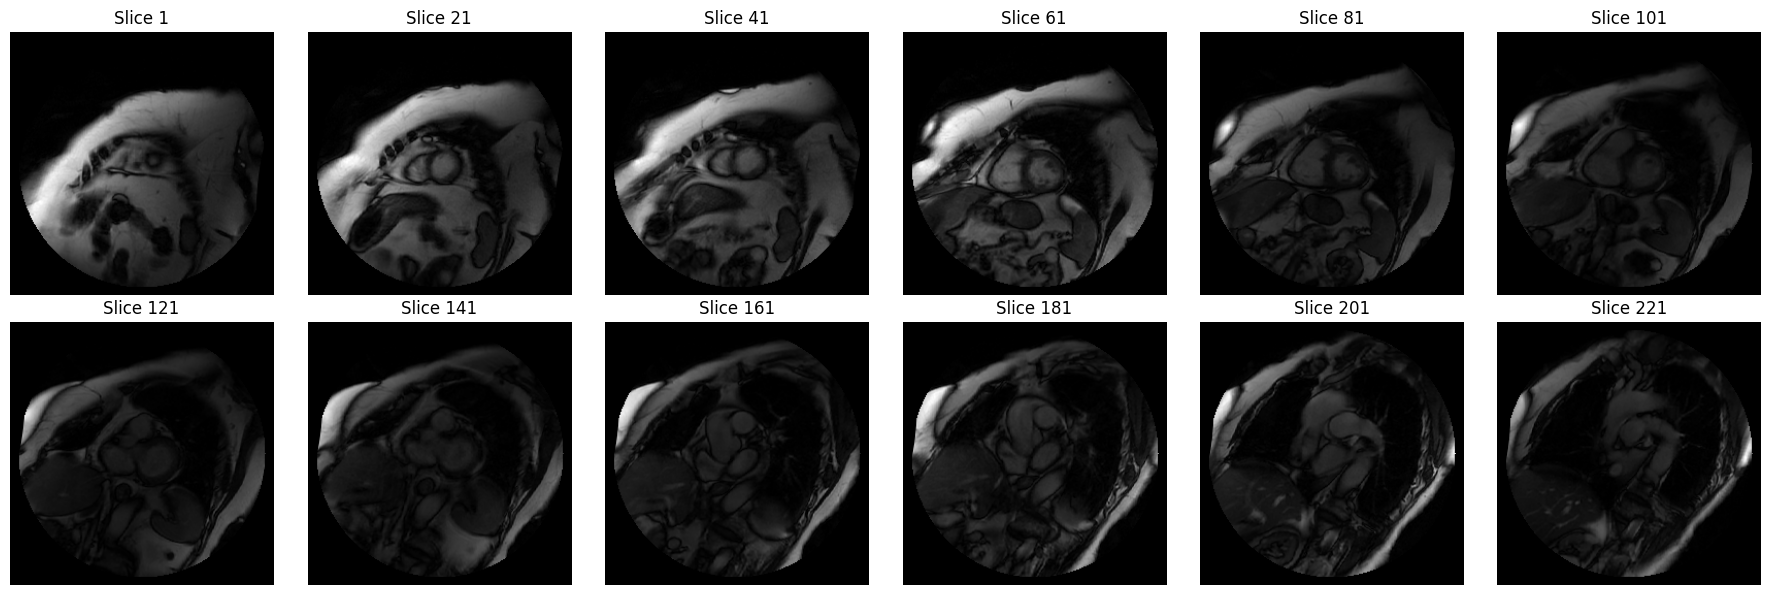

In [281]:
import matplotlib.pyplot as plt
import numpy as np

def show_slices(volume, num_columns=6, step=10):
    """
    Display selected DICOM slices in a grid format, skipping by a given step.

    Parameters:
    - volume (numpy array): 3D NumPy array containing the image stack.
    - num_columns (int): Number of columns in the figure (default: 6).
    - step (int): Step size to skip slices (default: 5).
    """
    slices = volume[::step]  # Extract slices at the given step
    num_slices = slices.shape[0]
    num_rows = int(np.ceil(num_slices / num_columns))  # Compute necessary rows

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 3))  # Adjust figure size

    for i in range(num_rows * num_columns):
        row, col = divmod(i, num_columns)  # Get row and column index

        if i < num_slices:
            axes[row, col].imshow(slices[i], cmap='gray')
            axes[row, col].set_title(f"Slice {i * step + 1}", fontsize=12)  # Adjusted index
            axes[row, col].axis("off")
        else:
            axes[row, col].axis("off")  # Hide unused subplots

    plt.tight_layout()
    plt.show()

# Example usage:
show_slices(volume, num_columns=6, step=20)


In [282]:
import matplotlib.pyplot as plt
import numpy as np

def show_overlay_slices(original_volume, segmented_volume, step=10, cmap='gray', alpha=0.2):
    """
    Displays a grid of slices with the segmented overlay on top of the original MRI images.

    Parameters:
    - original_volume (ndarray): The original 3D MRI volume.
    - segmented_volume (ndarray): The binary 3D segmented volume.
    - step (int): Step size to control the number of slices displayed (default: every 5 slices).
    - cmap (str): Colormap for the original image (default: 'gray').
    - alpha (float): Transparency of the overlay (default: 0.4).
    """

    num_slices = original_volume.shape[0]
    slice_indices = list(range(0, num_slices, step))  # Select slices with step size

    cols = 6  # Number of columns in grid
    rows = int(np.ceil(len(slice_indices) / cols))  # Determine number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))  # Adjust figure size
    axes = axes.flatten()  # Flatten in case grid is not perfectly filled

    for ax, idx in zip(axes, slice_indices):
        # Get corresponding slices
        original_slice = original_volume[idx]
        segmented_slice = segmented_volume[idx]

        # Convert segmentation mask to RGBA (Red overlay)
        overlay = np.zeros((*segmented_slice.shape, 4), dtype=np.float32)  # Create empty RGBA image
        overlay[..., 0] = 1.0  # Red channel
        overlay[..., 3] = segmented_slice * alpha  # Alpha channel (opacity based on mask)

        # Show the original image
        ax.imshow(original_slice, cmap=cmap)

        # Overlay segmentation in red with transparency
        ax.imshow(overlay)

        ax.set_title(f"Slice {idx + 1}/{num_slices}")
        ax.axis("off")  # Hide axis labels

    # Hide any unused subplots (if there are extra grid slots)
    for i in range(len(slice_indices), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


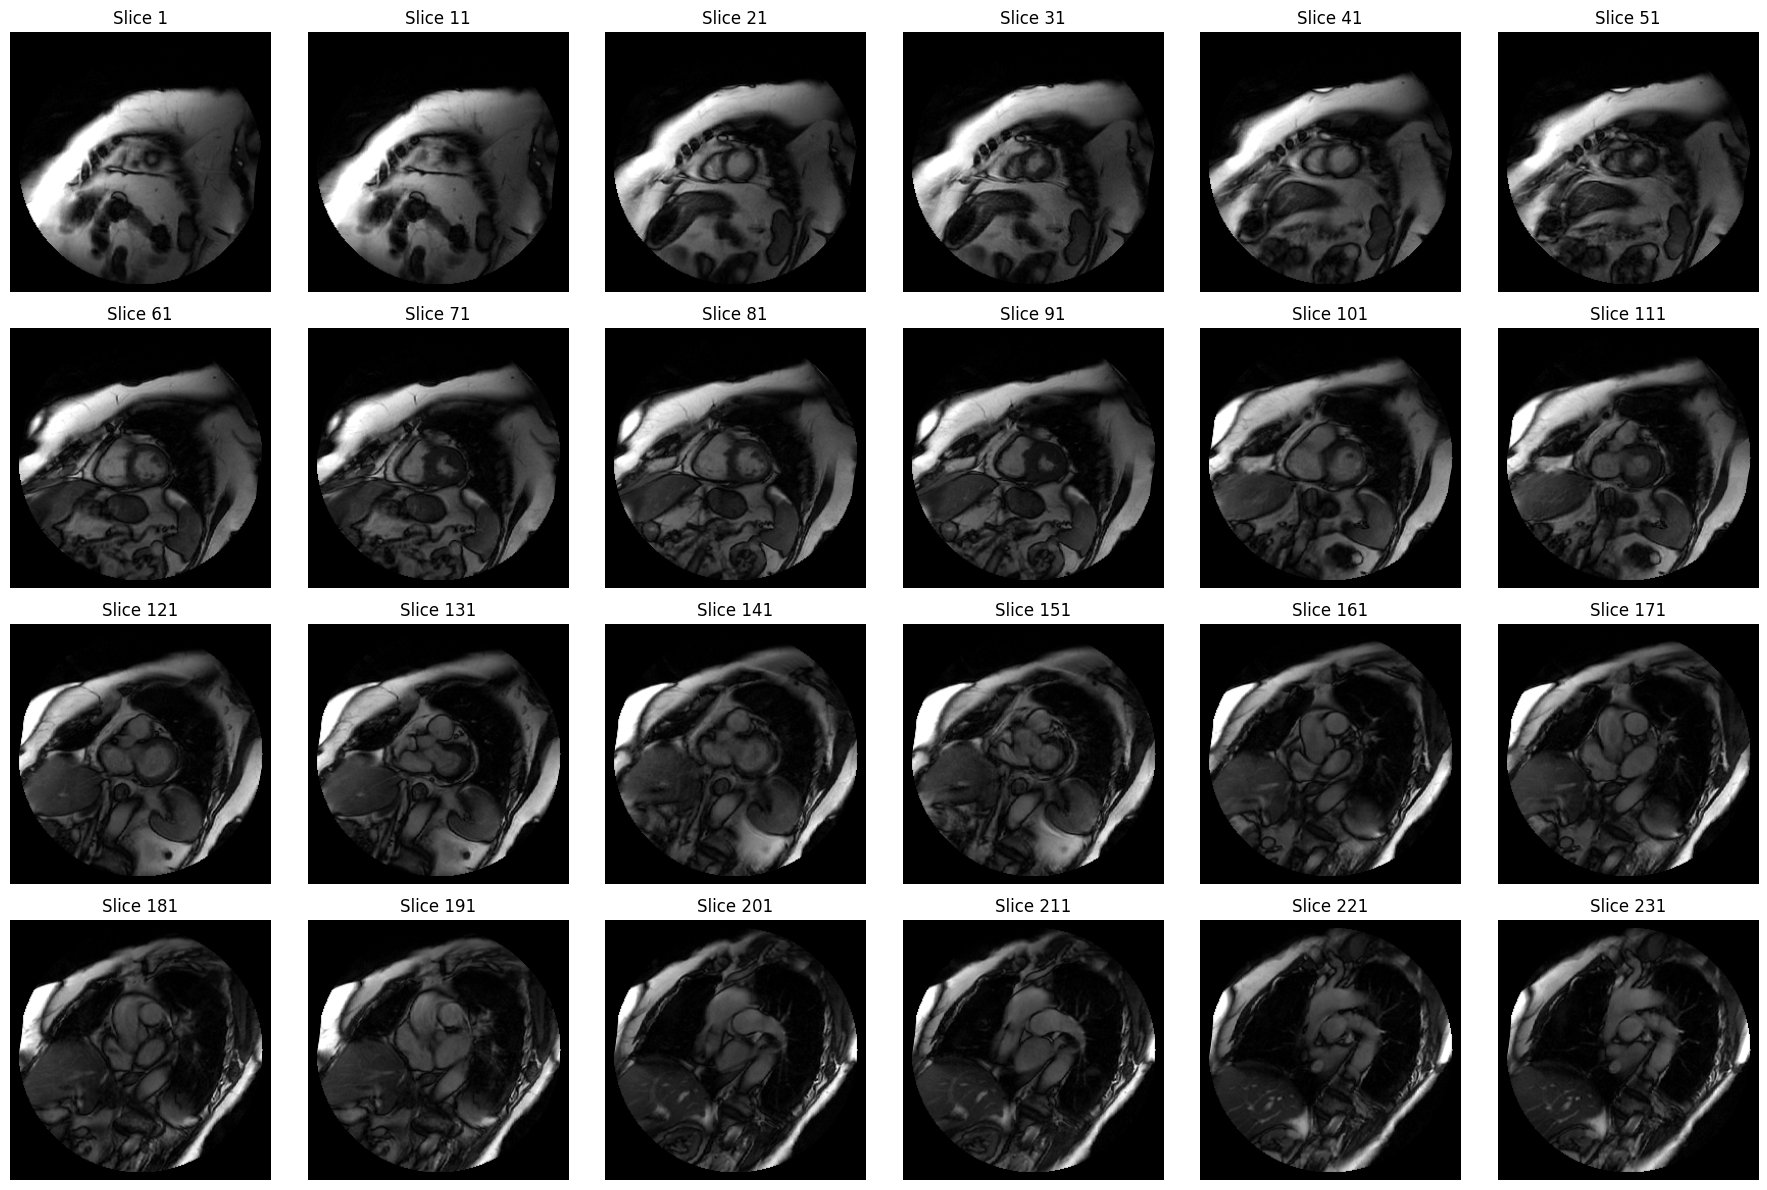

In [283]:
def normalize_volume(volume):
    # Clip out extreme values (optional, helps with outliers)
    volume = np.clip(volume, np.percentile(volume, 1), np.percentile(volume, 99))

    # Min-max normalization to [0, 1]
    volume = volume.astype(np.float32)
    volume -= volume.min()
    volume /= volume.max()

    return volume

normalized_volume = normalize_volume(volume)
show_slices(normalized_volume)

Since the heart is generally centered in the scan, we can create a Gaussian weight map that brightens the center of the image, helping the heart stand out for segmentation.

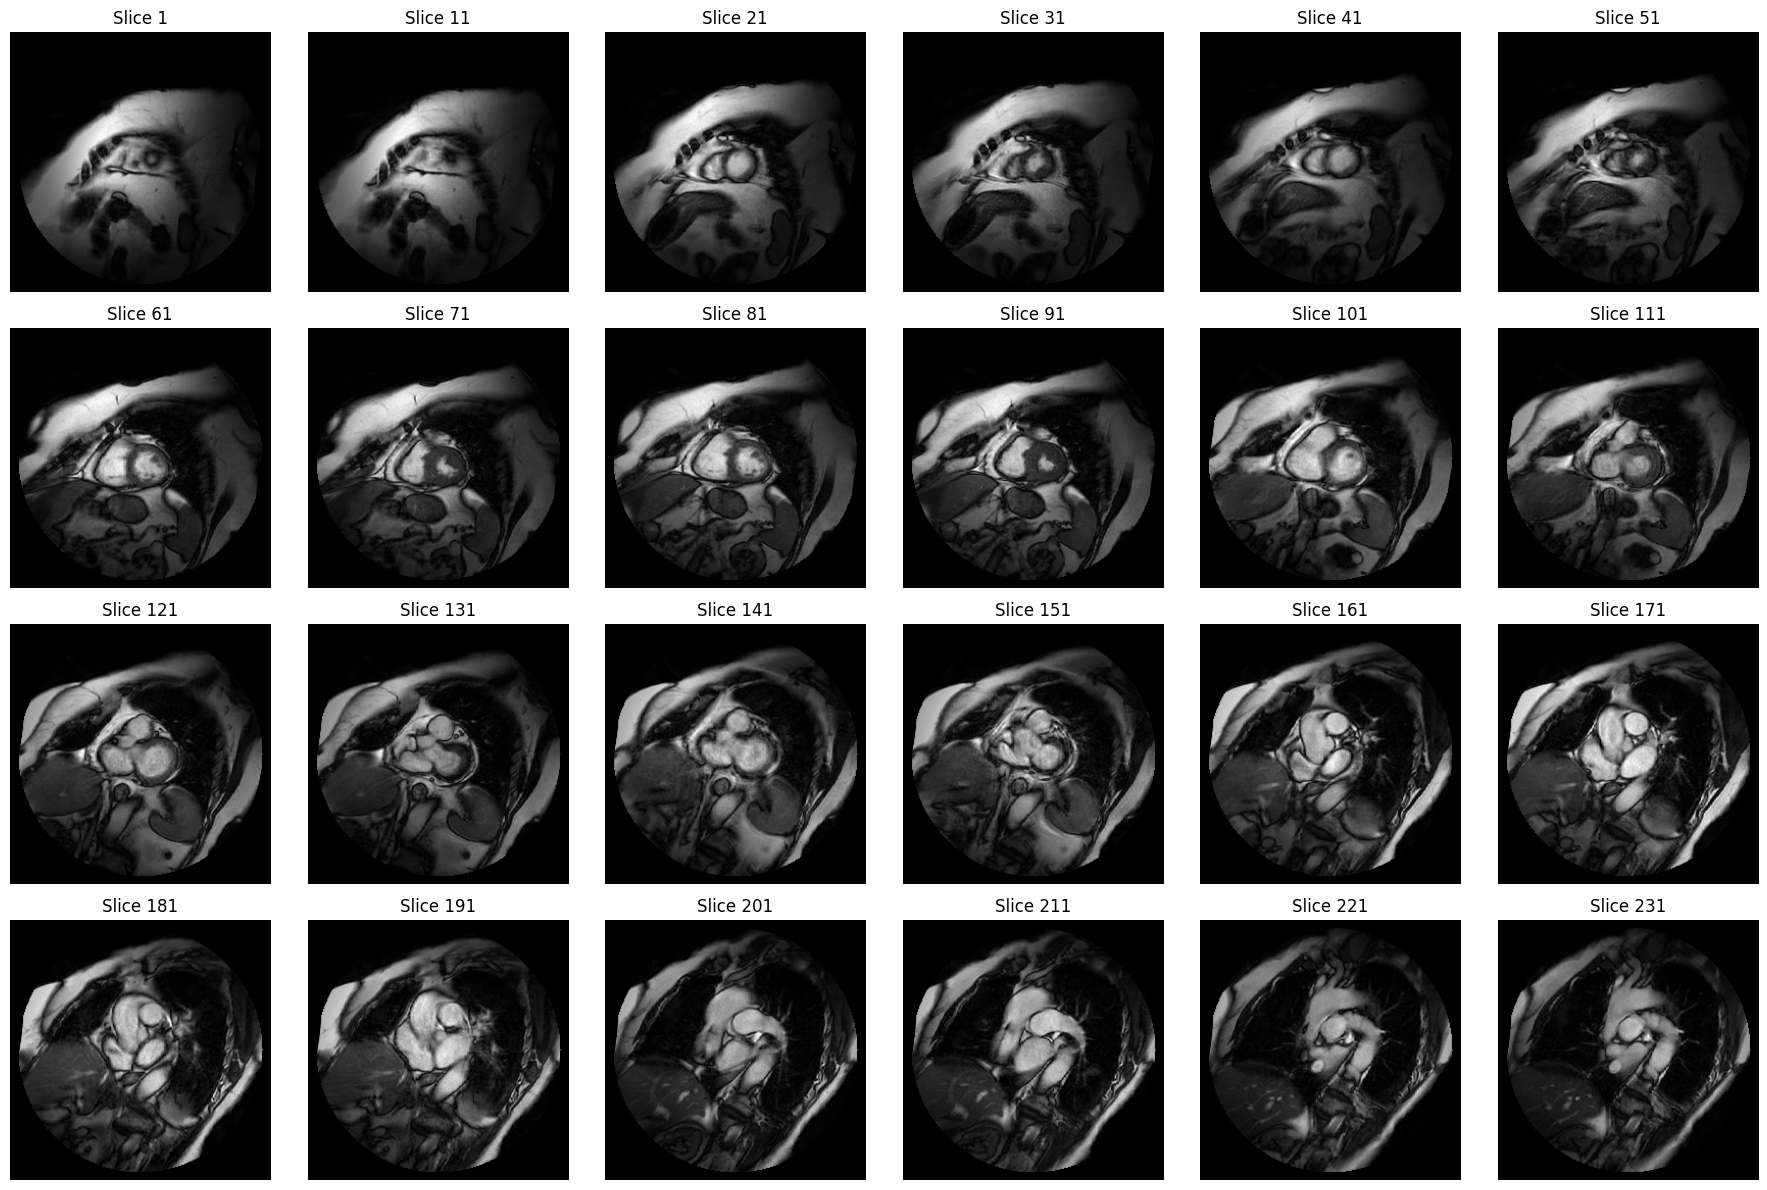

In [317]:
def apply_center_weighting(volume, alpha=0.5):
    """
    Enhance the image intensity towards the center using a Gaussian weight map.

    Parameters:
    - volume: 3D MRI volume.
    - alpha: Weighting factor (0.0 - 1.0).
    """
    z, y, x = volume.shape

    # Create a Gaussian weight map centered in the middle
    yy, xx = np.meshgrid(np.linspace(-1, 1, x), np.linspace(-1, 1, y))
    distance = np.sqrt(xx**2 + yy**2)
    weight_map = np.exp(-4 * distance**2)  # Gaussian-like falloff

    weighted_volume = np.zeros_like(volume)

    # Apply the weight map to each slice
    for i in range(z):
        weighted_volume[i] = volume[i] * (1 + alpha * weight_map)

    return weighted_volume

# Apply center weighting
weighted_volume = apply_center_weighting(normalized_volume, alpha=4)
show_slices(weighted_volume)

The heart is near the center of the image, crop the image to reduce noise and segmentation of other anatomical features

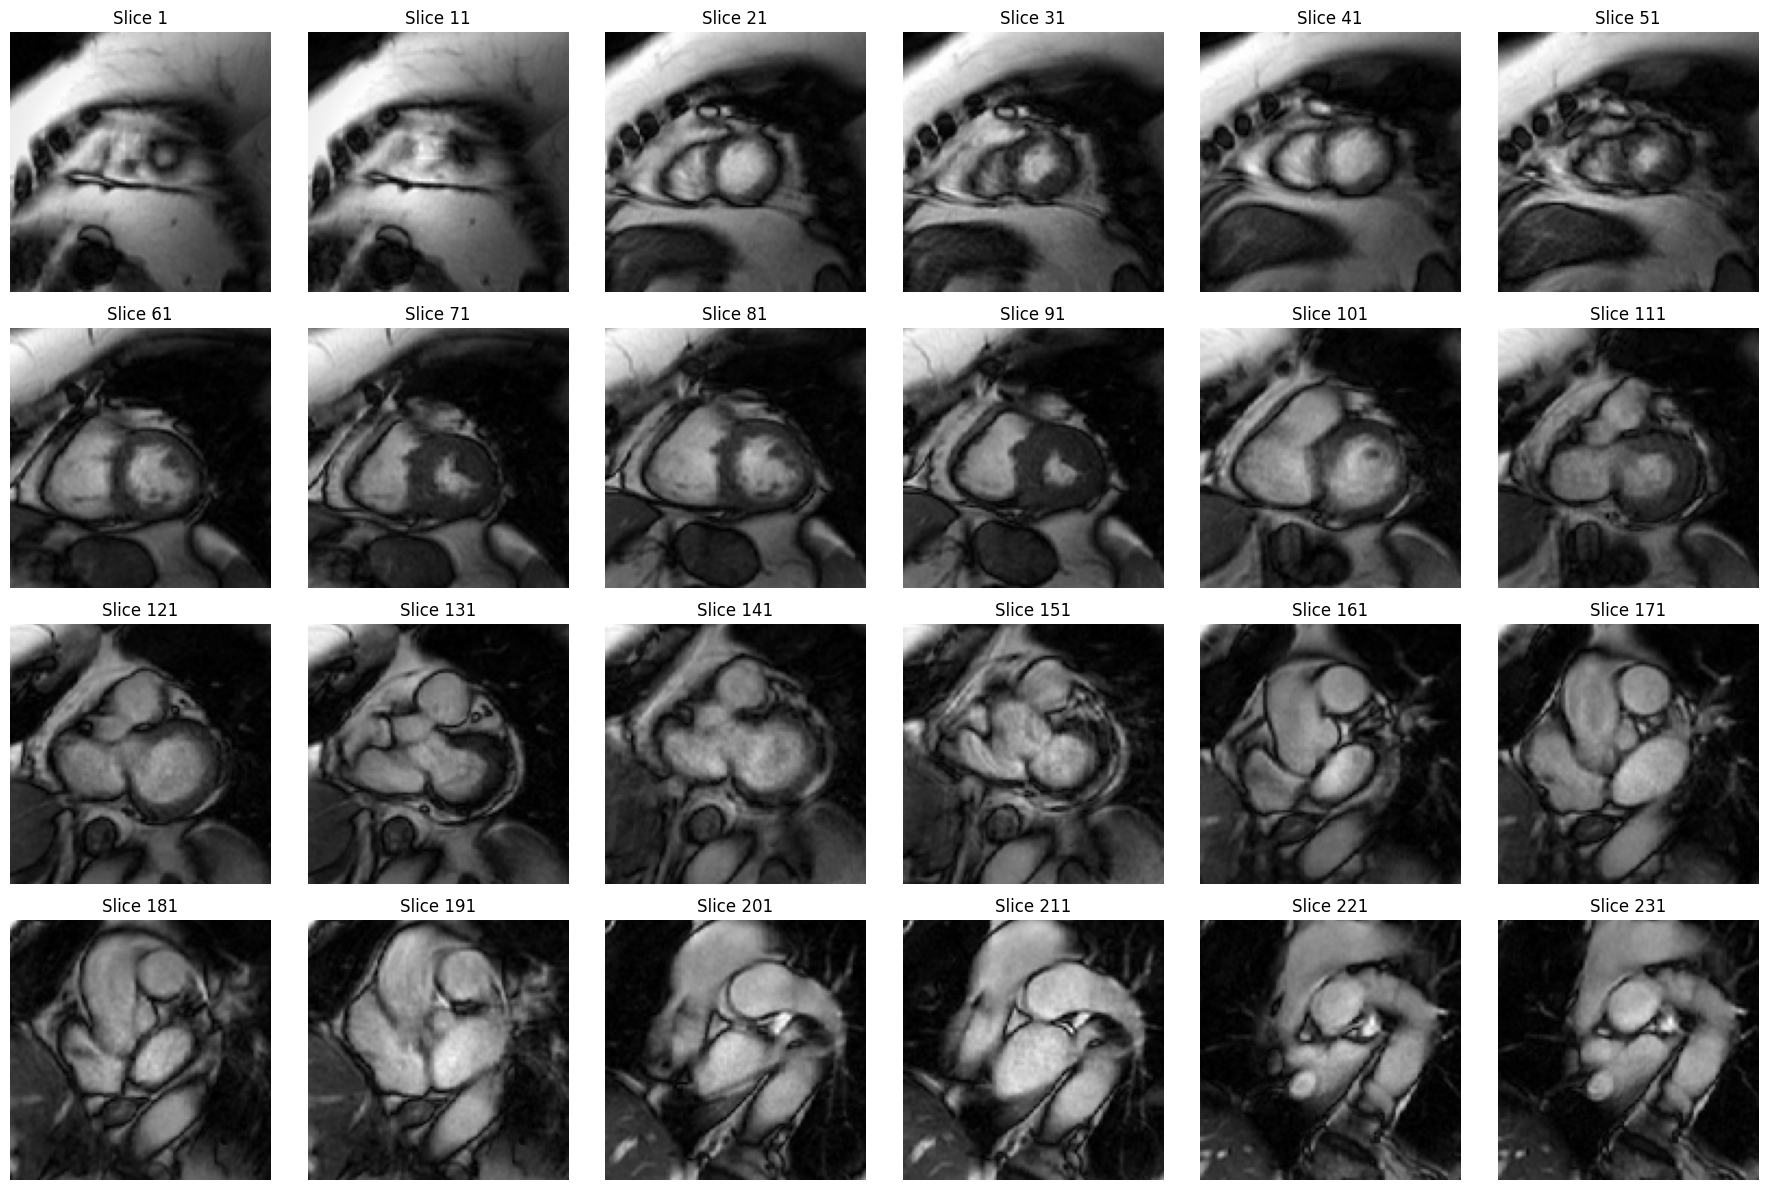

In [320]:
def crop_center(volume, crop_size):
    """
    Crop the center region of a 3D volume.

    Parameters:
    - volume: 3D NumPy array (z, y, x).
    - crop_size: Tuple (crop_height, crop_width).

    Returns:
    - Cropped volume.
    """
    z, y, x = volume.shape
    crop_height, crop_width = crop_size

    # Calculate center coordinates
    center_y, center_x = y // 2, x // 2

    # Define cropping boundaries
    y_min = max(center_y - crop_height // 2, 0)
    y_max = min(center_y + crop_height // 2, y)
    x_min = max(center_x - crop_width // 2, 0)
    x_max = min(center_x + crop_width // 2, x)

    # Crop the volume
    cropped_volume = volume[:, y_min:y_max, x_min:x_max]

    return cropped_volume

# Crop the center 256x256 region
cropped_volume = crop_center(normalized_volume, crop_size=(120, 120))

# Apply center weighting
cropped_volume = apply_center_weighting(cropped_volume, alpha=1)
show_slices(cropped_volume)

Once we’ve boosted the heart region, we can use Otsu’s method for global thresholding. It automatically finds the best threshold value! We will also remove anatomical structures touching the border of the image since they will most likely not be left ventricle anatomy

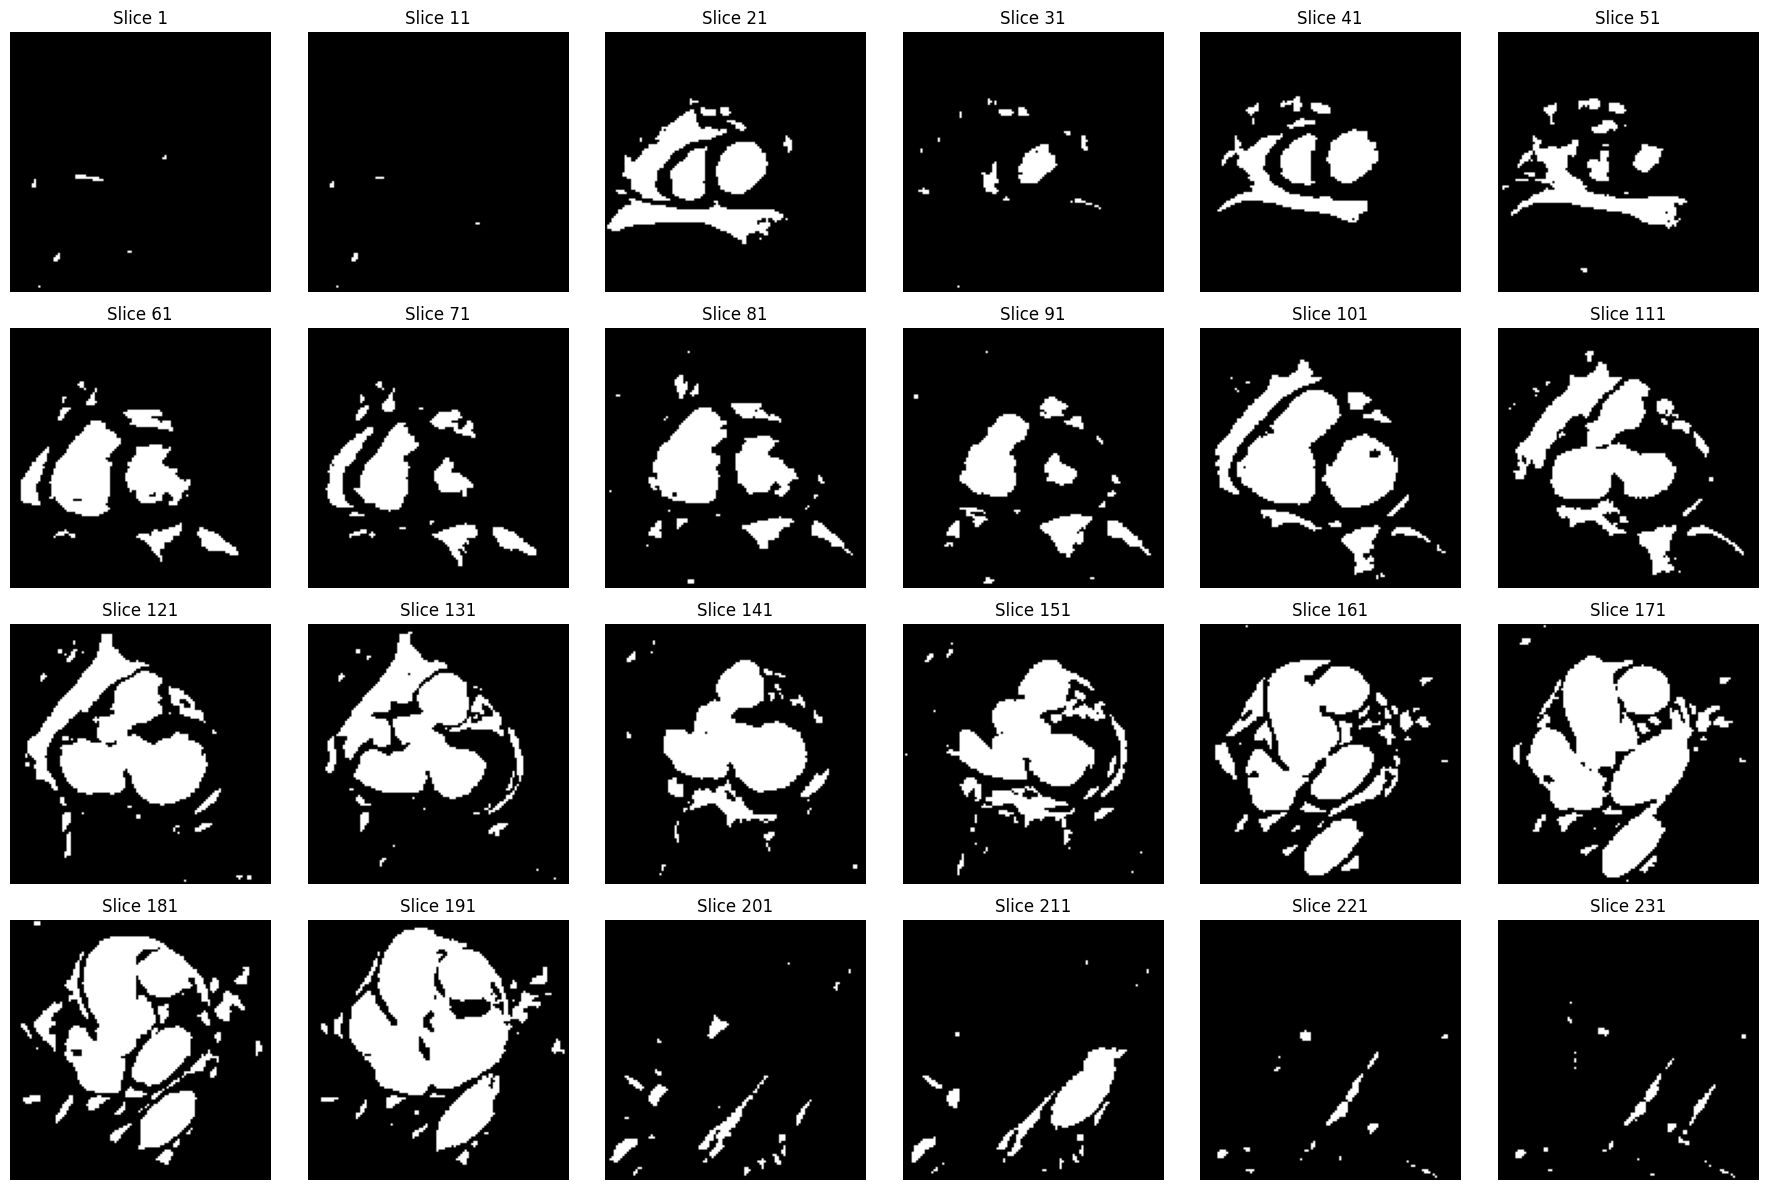

In [321]:
import numpy as np
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.segmentation import clear_border

def remove_border_components(binary_slice):
    """
    Remove connected components touching the borders of the image.

    Parameters:
    - binary_slice (numpy array): A 2D binary image.

    Returns:
    - cleaned_slice (numpy array): Binary image with border-touching components removed.
    """
    # Label connected components in the binary mask
    labeled_slice = label(binary_slice)

    # Remove components touching the image borders
    cleaned_slice = clear_border(labeled_slice)

    # Convert back to binary
    return cleaned_slice > 0

def segment_heart_otsu(volume):
    """
    Segment the heart using Otsu's thresholding and remove border-touching components.

    Steps:
    1. Apply Otsu's thresholding to segment potential heart regions.
    2. Remove any connected components touching the image borders.
    3. Return the cleaned segmented volume.

    Parameters:
    - volume (numpy array): 3D NumPy array containing the image stack.

    Returns:
    - segmented_volume (numpy array): Binary volume with only the heart region.
    """

    segmented_volume = np.zeros_like(volume, dtype=bool)  # Initialize output

    for i in range(volume.shape[0]):  # Iterate over slices
        slice_img = volume[i]

        # Step 1: Apply Otsu’s thresholding
        thresh = threshold_otsu(slice_img)
        binary_slice = slice_img > thresh  # Convert to binary mask

        # Step 2: Remove border-touching components
        cleaned_slice = remove_border_components(binary_slice)

        # Store in output volume
        segmented_volume[i] = cleaned_slice

    return segmented_volume.astype(np.uint8)  # Convert to uint8 for visualization

# Apply segmentation with border removal
segmented_volume = segment_heart_otsu(cropped_volume)

# Display slices
show_slices(segmented_volume)


Bias towards circular structures

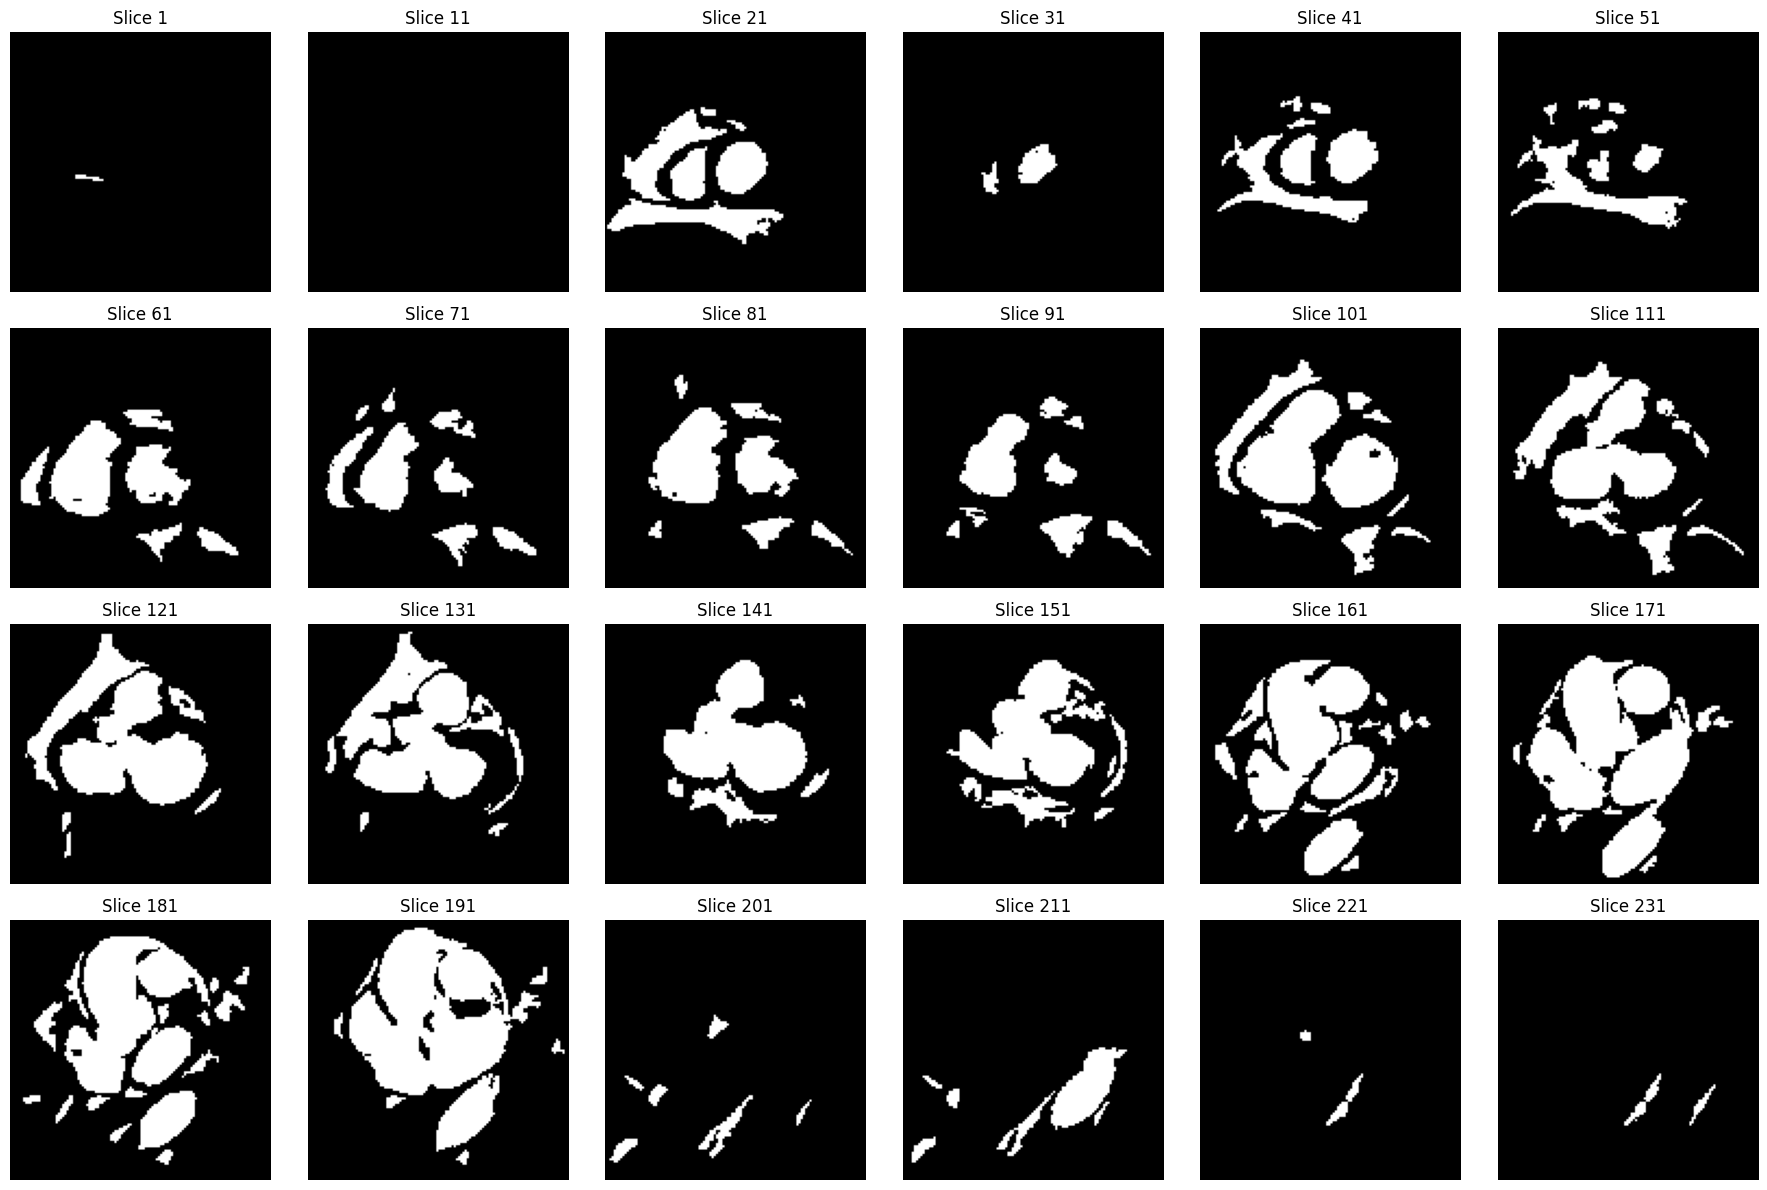

In [343]:
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects

def filter_circular_regions(segmented_volume, circularity_thresh=0.6, min_size=100):
    """
    Keep only circular regions in a segmented 3D volume.

    Parameters:
    - segmented_volume: 3D binary NumPy array (segmentation mask).
    - circularity_thresh: Circularity threshold (higher = more circular).
    - min_size: Minimum region size to keep (removes small noise).

    Returns:
    - Filtered 3D binary mask with mostly circular regions.
    """
    filtered_volume = np.zeros_like(segmented_volume)

    for z in range(segmented_volume.shape[0]):
        slice_mask = segmented_volume[z]

        # Label connected components
        labeled_mask = label(slice_mask)

        for region in regionprops(labeled_mask):
            # Calculate circularity: (4 * pi * area) / perimeter^2
            if region.perimeter > 0:  # Avoid division by zero
                circularity = (4 * np.pi * region.area) / (region.perimeter ** 2)

                # Keep region if circular enough and above min size
                if circularity >= circularity_thresh and region.area >= min_size:
                    filtered_volume[z][labeled_mask == region.label] = 1

    return filtered_volume

# Apply circular filtering to segmentation
filtered_segmentation = filter_circular_regions(segmented_volume, circularity_thresh=0.1, min_size=20)

# Visualize the result
show_slices(filtered_segmentation)


Apply watershed to separate connected components

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2].


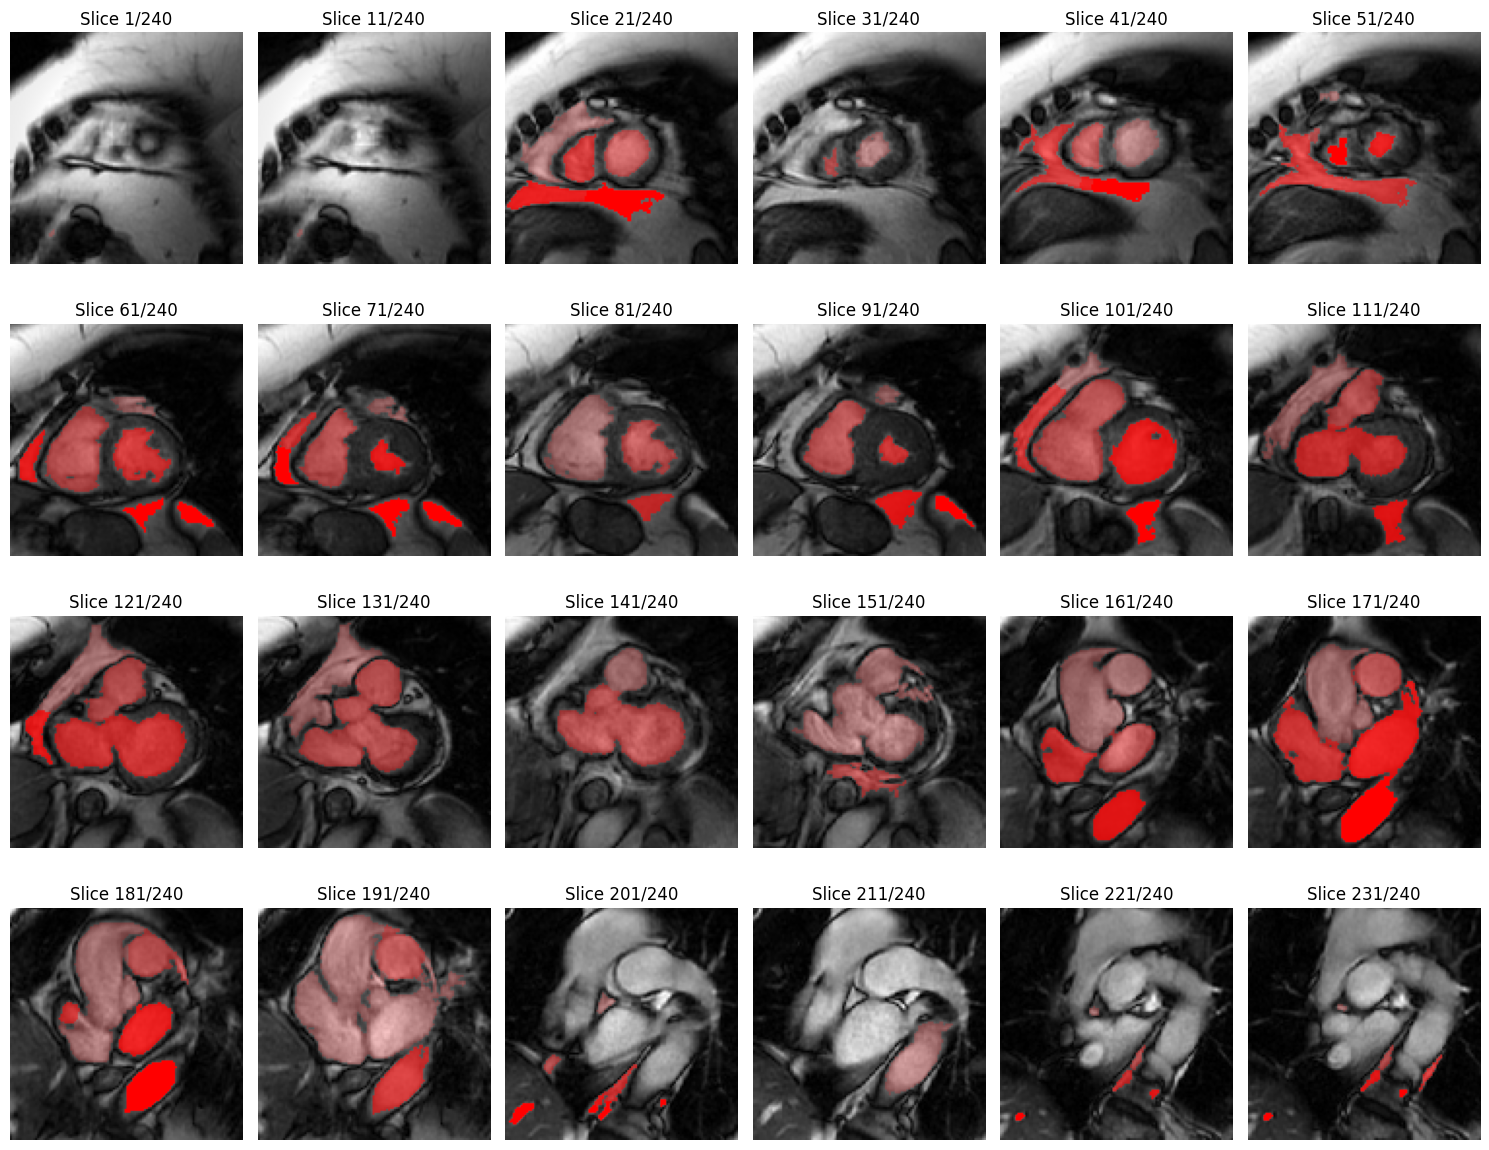

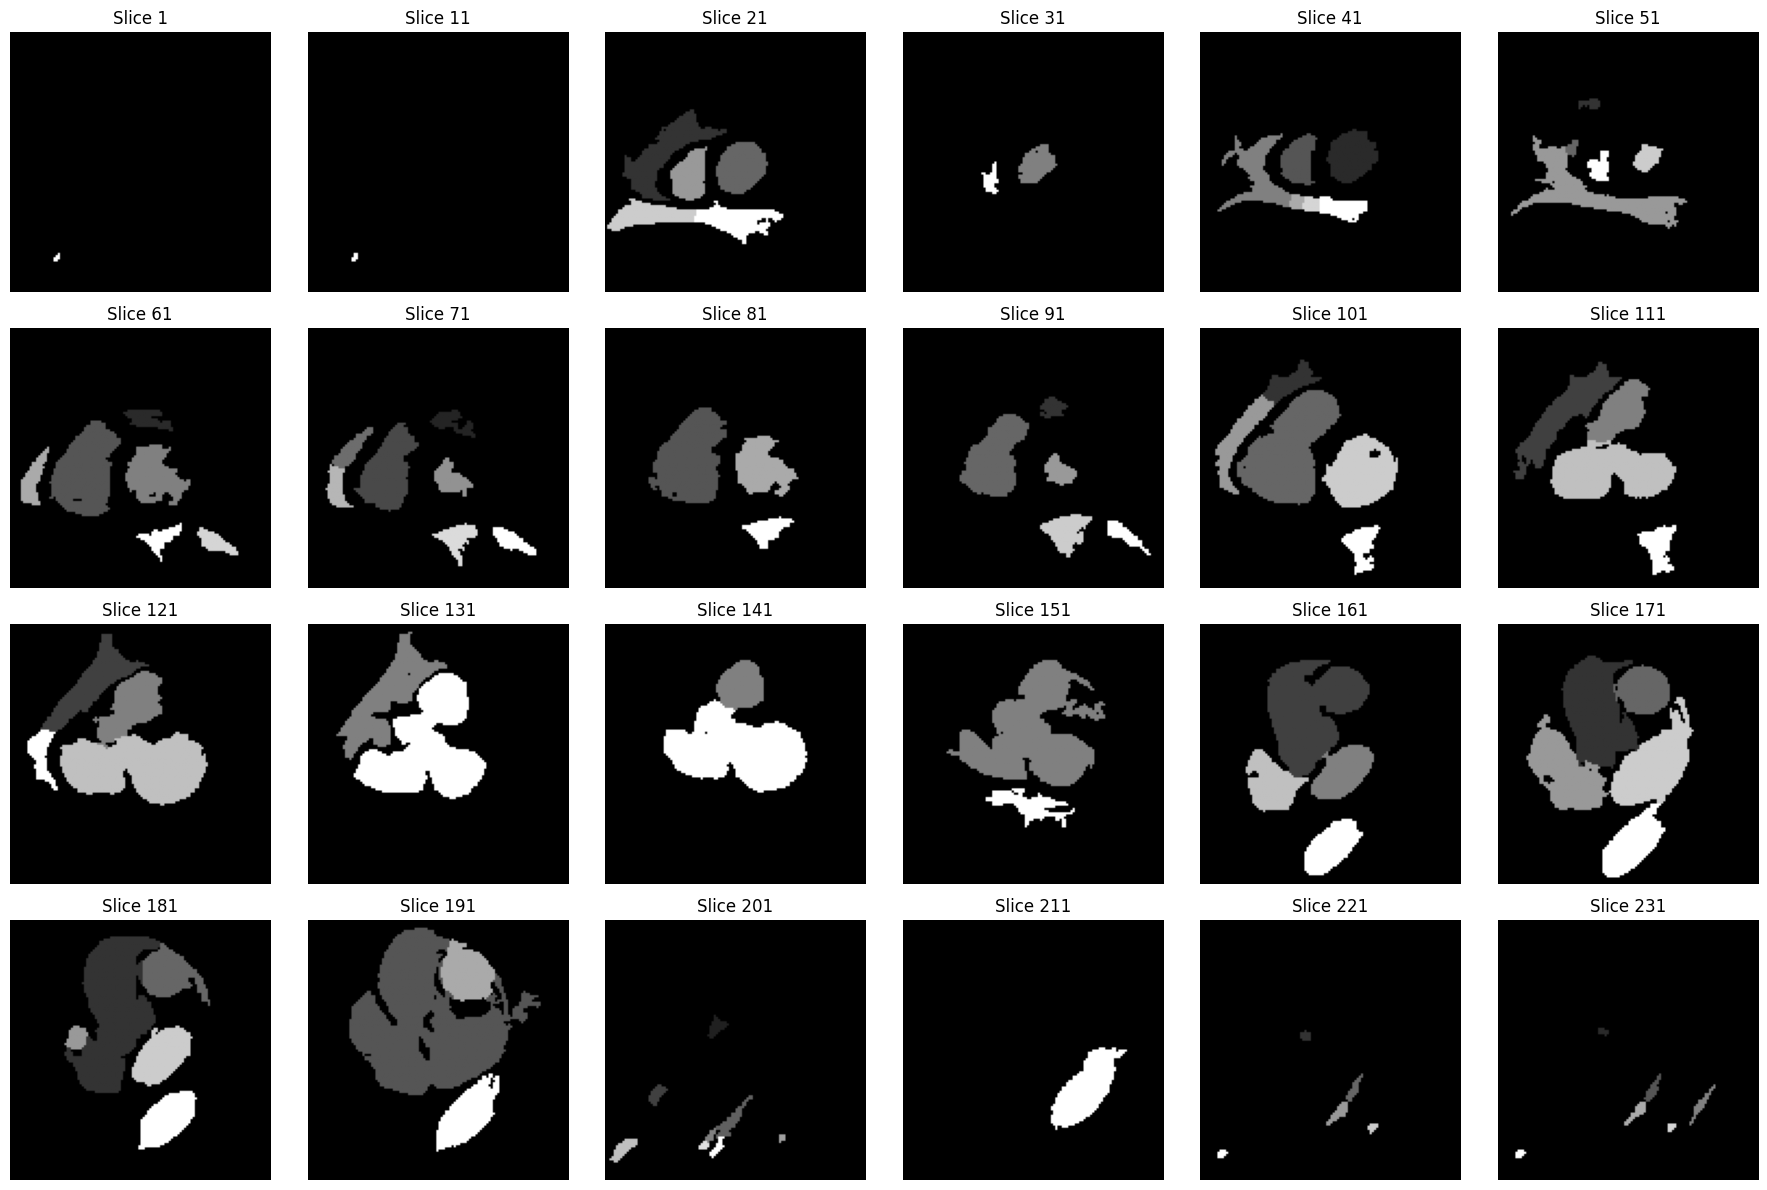

In [339]:
import numpy as np
import cv2
from scipy.ndimage import distance_transform_edt, gaussian_filter
from skimage.segmentation import watershed
from skimage.filters import sobel
from skimage.measure import label

def improved_watershed(segmented_volume, blur_sigma=2, distance_exp=0.7, seed_quantile=0.65):
    """
    Applies an improved Watershed segmentation across all slices in a 3D volume.
    - Uses Gaussian-blurred Sobel for smoother edge detection.
    - Enhances distance map contrast for better LV separation.
    - Adapts seed selection to account for intensity variations.

    Parameters:
    - segmented_volume (ndarray): Binary 3D array from Otsu thresholding.
    - blur_sigma (float): Standard deviation for Gaussian blur (default: 1.5).
    - distance_exp (float): Exponent for distance transform enhancement (default: 1.2).
    - seed_quantile (float): Quantile threshold for selecting seeds (default: 0.5).

    Returns:
    - watershed_labels (ndarray): 3D array with labeled regions after Watershed segmentation.
    """

    # Initialize output volume
    watershed_labels = np.zeros_like(segmented_volume, dtype=np.int32)

    for i in range(segmented_volume.shape[0]):  # Process each slice
        binary_slice = segmented_volume[i]

        if np.sum(binary_slice) == 0:
            continue  # Skip empty slices

        # Step 1: Apply Gaussian blur to smooth noise before Sobel
        smoothed_slice = gaussian_filter(binary_slice.astype(float), sigma=blur_sigma)

        # Step 2: Compute edges using Sobel on the smoothed image
        edges = sobel(smoothed_slice)

        # Step 3: Compute the distance transform (inner areas have higher values)
        distance_map = distance_transform_edt(binary_slice)

        # Step 4: Enhance distance contrast for better watershed performance
        distance_map = distance_map ** distance_exp

        # Step 5: Adapt seed threshold based on the intensity distribution
        seed_threshold = np.quantile(distance_map[distance_map > 0], seed_quantile)
        seeds = distance_map > seed_threshold

        # Step 6: Label connected components in the seed map
        markers = label(seeds)

        # Step 7: Apply Watershed with edges as the barrier
        ws_result = watershed(edges, markers, mask=binary_slice)

        # Store result
        watershed_labels[i] = ws_result

    return watershed_labels

# Apply the improved watershed function
watershed_volume = improved_watershed(filtered_segmentation)

# Visualize the slices
show_overlay_slices(cropped_volume, watershed_volume)
show_slices(watershed_volume)


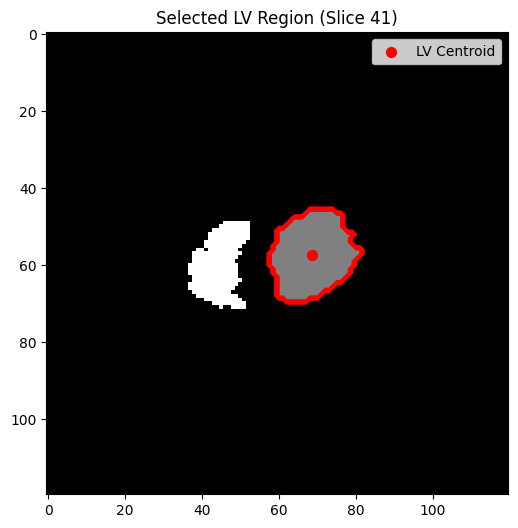

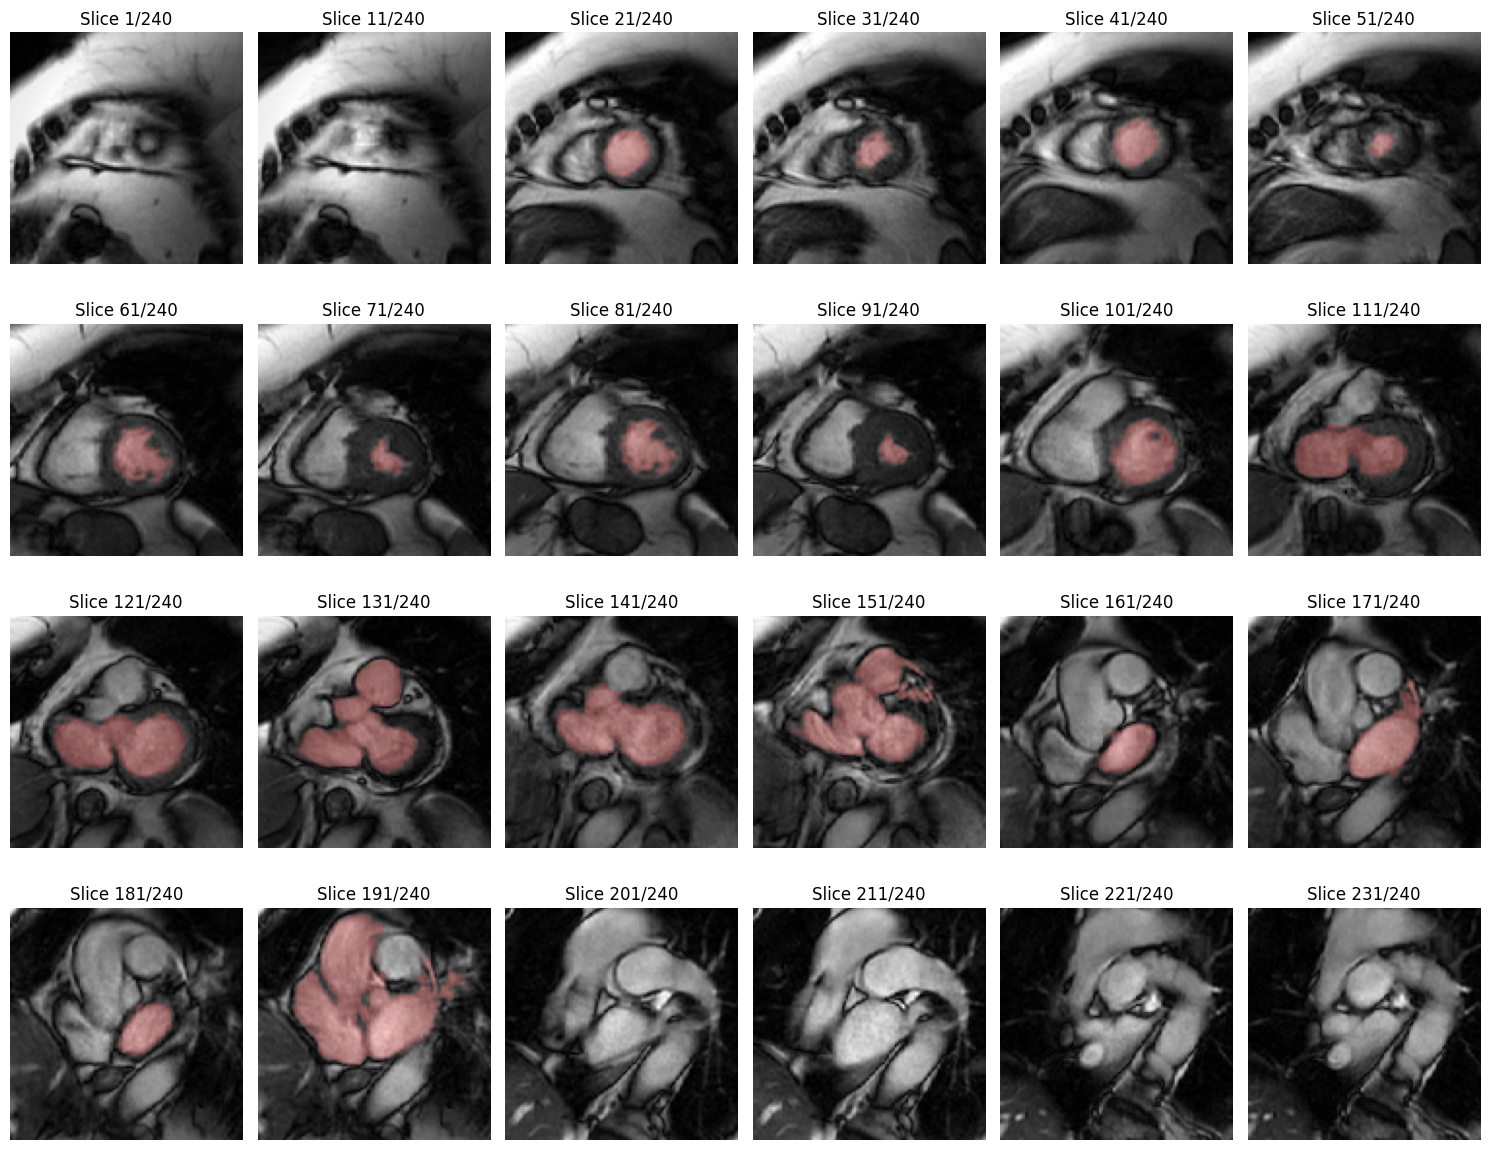

In [340]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops, label

def LV_isolation(watershed_labels, min_size=50, max_size=4000, 
                 min_size_reference=400, slice_range=(41, 100), 
                 sample_slices=4, visualize=True):
    """
    Identifies the Left Ventricle (LV) in a reference slice and extends segmentation
    by selecting the region in each slice that has both:
      1. The highest proportion of pixel overlap with the reference LV region.
      2. The closest centroid distance to the reference LV region.
      3. For slices below the reference, regions 1.5x or larger than the reference LV are ignored.

    Parameters:
    - watershed_labels (ndarray): 3D labeled array from segmentation.
    - min_size (int): Global minimum allowable region size.
    - max_size (int): Global maximum allowable region size.
    - min_size_reference (int): Minimum size for selecting the reference LV region.
    - slice_range (tuple): Range of slices to search for the reference LV.
    - sample_slices (int): Number of slices to sample within slice_range.
    - visualize (bool): If True, displays the chosen LV region.

    Returns:
    - lv_volume (ndarray): 3D binary array containing only the LV segmentation.
    """

    lv_volume = np.zeros_like(watershed_labels, dtype=np.uint8)
    num_slices = watershed_labels.shape[0]

    # Step 1: Identify LV in a well-segmented reference slice
    lower_half_slices = np.linspace(slice_range[0], slice_range[1], sample_slices, dtype=int)
    best_lv_centroid = None
    best_lv_label = None
    chosen_slice = None
    reference_lv_size = None  # Store reference LV size

    for i in lower_half_slices:
        slice_labels = label(watershed_labels[i])
        if np.max(slice_labels) == 0:
            continue  # Skip empty slices

        # Apply reference slice threshold
        regions = [r for r in regionprops(slice_labels) if min_size_reference <= r.area <= max_size]

        if not regions:
            continue

        # Find the most circular LV region
        most_circular_region = max(regions, key=lambda r: (4 * np.pi * r.area) / (r.perimeter ** 2 + 1e-5))  
        best_lv_centroid = most_circular_region.centroid
        reference_lv_size = most_circular_region.area  # Store reference LV size
        chosen_slice = i
        break  # Take the first well-defined LV region

    if best_lv_centroid is None:
        raise ValueError("Could not identify a well-segmented LV region in slices 41-100.")

    # Step 2: Find the label containing this LV centroid
    slice_labels = label(watershed_labels[chosen_slice])
    for region in regionprops(slice_labels):
        if min_size <= region.area <= max_size:  # Global threshold applied here
            if region.bbox[0] <= best_lv_centroid[0] <= region.bbox[2] and \
               region.bbox[1] <= best_lv_centroid[1] <= region.bbox[3]:
                best_lv_label = region.label
                break  

    if best_lv_label is None:
        raise ValueError("Could not map the chosen LV centroid to a label in the reference slice.")

    # Assign LV label in the best slice
    lv_volume[chosen_slice] = (slice_labels == best_lv_label)  

    # Step 3: Use the reference LV as a mask for all slices
    reference_mask = lv_volume[chosen_slice]  # Fixed reference LV mask
    reference_centroid = best_lv_centroid  # Fixed reference LV centroid

    for i in range(num_slices):
        if i == chosen_slice:
            continue  

        slice_labels = label(watershed_labels[i])
        if np.max(slice_labels) == 0:
            continue  

        # Apply global min/max size threshold
        regions = [r for r in regionprops(slice_labels) if min_size <= r.area <= max_size]  
        best_region = None
        best_score = 0  # Higher is better (overlap & proximity combined)

        # Step 1: Find the best region based on overlap ratio & centroid distance
        for region in regions:
            # Apply additional constraint only for slices **below** the reference (i.e., slices 1–41)
            if i < chosen_slice and region.area >= 1.5 * reference_lv_size:
                continue  # Skip regions that are 1.5x larger than the reference LV

            region_mask = (slice_labels == region.label)
            overlap = np.sum(reference_mask & region_mask)  # Count overlapping pixels
            overlap_ratio = overlap / (region.area + 1e-5)  # Proportion of region that overlaps

            # Compute centroid distance
            centroid_x, centroid_y = region.centroid
            distance = np.sqrt((centroid_x - reference_centroid[0]) ** 2 + (centroid_y - reference_centroid[1]) ** 2)

            # Define the score: prioritize overlap but prefer closer centroids
            score = overlap_ratio - (0.001 * distance)  # Small weight for distance

            if score > best_score:
                best_score = score
                best_region = region

        # Step 2: Assign the best region found
        if best_region:
            lv_volume[i] = (slice_labels == best_region.label)


    # Visualization of the chosen LV region
    if visualize:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(watershed_labels[chosen_slice], cmap="gray")
        ax.contour(lv_volume[chosen_slice], colors="r", linewidths=1.5)  # Overlay LV contour
        ax.scatter(best_lv_centroid[1], best_lv_centroid[0], c="red", s=50, label="LV Centroid")  

        # Display information
        ax.set_title(f"Selected LV Region (Slice {chosen_slice})")
        ax.legend()
        plt.show()

    return lv_volume


# Run Left Ventricle Isolation with visualization
left_ventricle_isolation = LV_isolation(watershed_volume, visualize=True)

# Display Results
show_overlay_slices(cropped_volume, left_ventricle_isolation)


 morphological opening and closing to remove small specks and fill holes

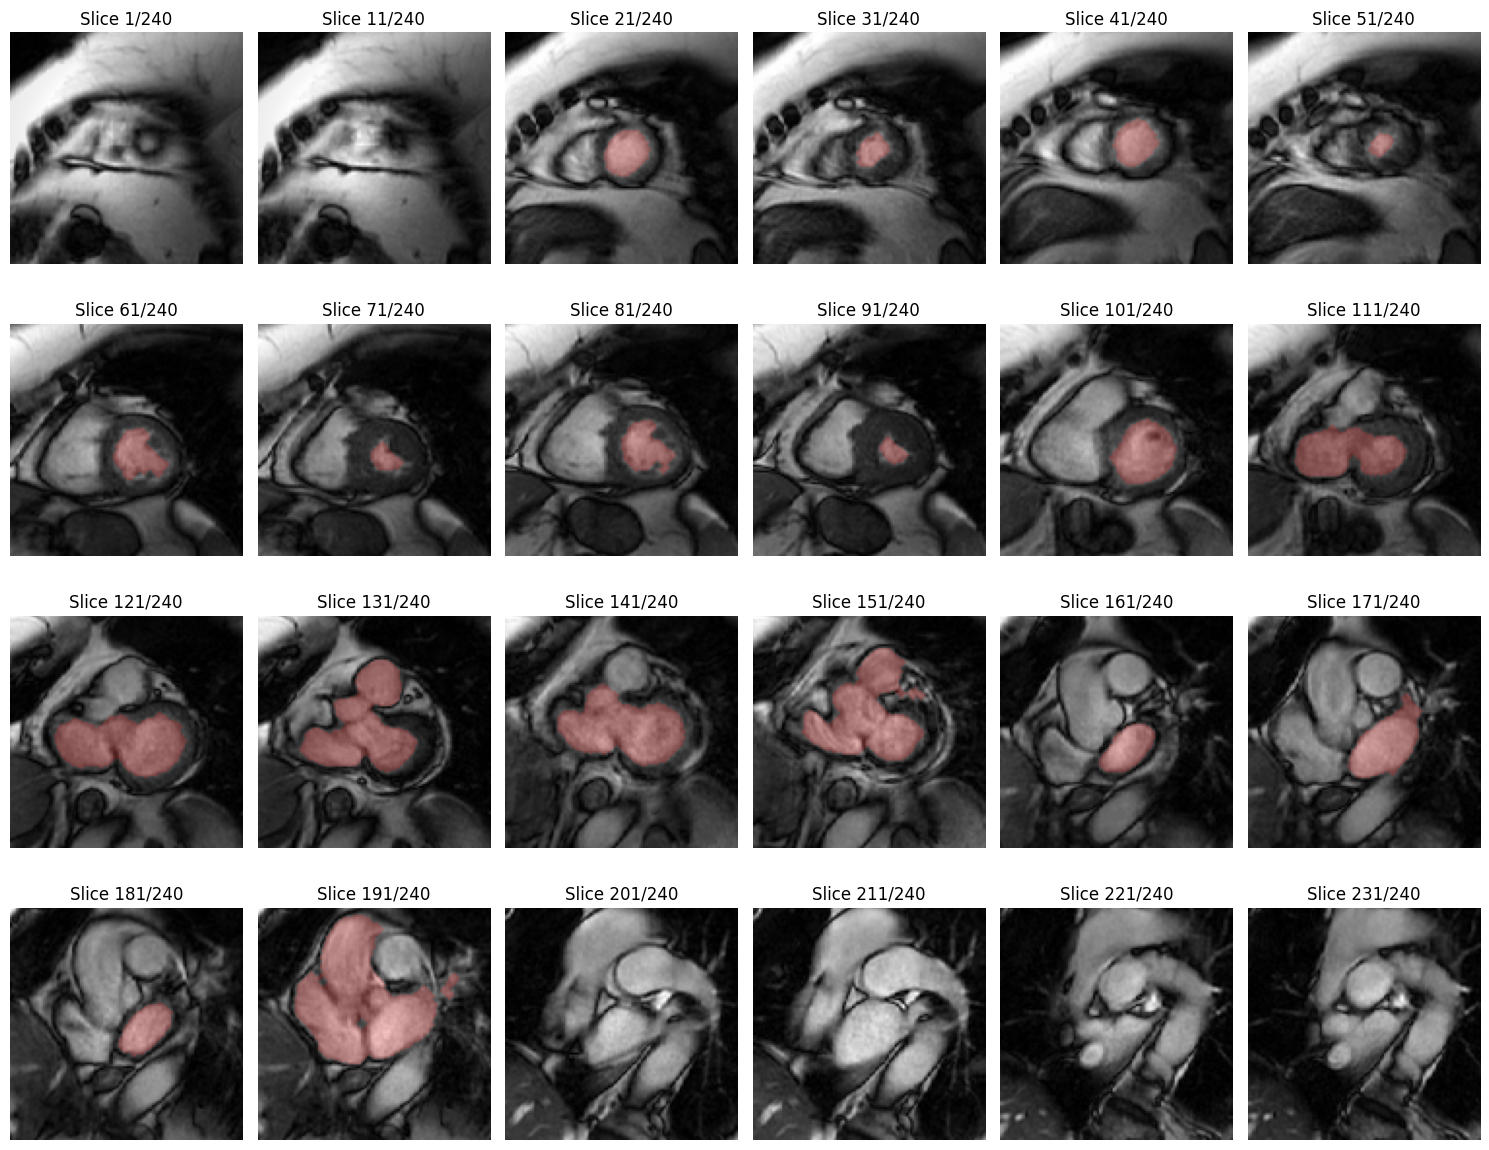

In [ ]:
from skimage.morphology import binary_opening, binary_closing, disk

def clean_segmentation(volume, radius=1):
    struct_elem = disk(radius)  # 2D circular element

    cleaned_volume = np.zeros_like(volume)
    for i in range(volume.shape[0]):
        cleaned_slice = binary_closing(binary_opening(volume[i], struct_elem), struct_elem)
        cleaned_volume[i] = cleaned_slice

    return cleaned_volume

cleaned_volume = clean_segmentation(left_ventricle_isolation, radius=2)

show_overlay_slices(cropped_volume, cleaned_volume)

# Trying to Capture the left ventricle thickness

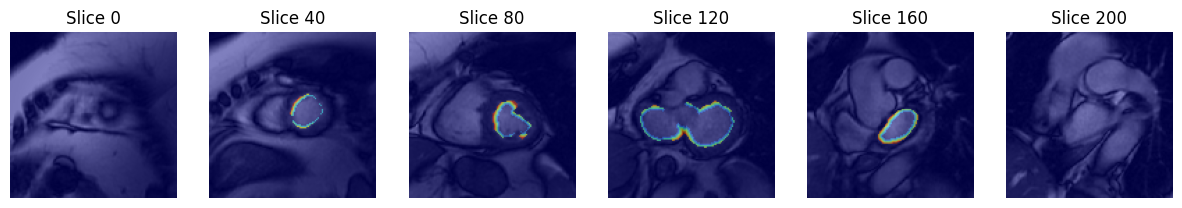

In [346]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt, binary_dilation, gaussian_filter, binary_closing
from skimage.filters import sobel, threshold_otsu
from skimage.measure import label, find_contours
from skimage.segmentation import active_contour

def compute_lv_wall_thickness(cleaned_volume, cropped_volume, dilation_radius=5, sigma=2):
    """
    Computes LV wall thickness using edge detection and low-intensity region segmentation.

    Parameters:
    - cleaned_volume (ndarray): Binary 3D array with LV segmentation (inner wall).
    - cropped_volume (ndarray): Original grayscale 3D image.
    - dilation_radius (int): Number of pixels to expand LV region outward.
    - sigma (float): Gaussian smoothing for better edge detection.

    Returns:
    - thickness_maps (ndarray): 3D array with LV wall thickness per pixel.
    """

    thickness_maps = np.zeros_like(cleaned_volume, dtype=np.float32)

    for i in range(cleaned_volume.shape[0]):  # Iterate over slices
        lv_mask = cleaned_volume[i]  # LV segmentation (inner boundary)
        original_slice = cropped_volume[i]  # Original MRI slice

        if np.sum(lv_mask) == 0:
            continue  # Skip empty slices

        # Step 1: Expand LV Mask (Estimate Myocardial Region)
        expanded_lv_mask = binary_dilation(lv_mask, iterations=dilation_radius)

        # Step 2: Identify Low-Intensity Myocardium (Outer Wall)
        smoothed_slice = gaussian_filter(original_slice.astype(float), sigma=sigma)
        low_intensity_threshold = threshold_otsu(smoothed_slice[expanded_lv_mask])  # Adaptive threshold
        myocardium_mask = (smoothed_slice < low_intensity_threshold) & expanded_lv_mask

        # Step 3: Use Edge Detection (Sobel) for Refinement
        edges = sobel(smoothed_slice)
        edge_mask = edges > np.percentile(edges[expanded_lv_mask], 75)  # Keep strong edges

        # Step 4: Fill Gaps in Myocardial Segmentation
        refined_myocardium = binary_closing(myocardium_mask | edge_mask, iterations=2)

        # Step 5: Compute Distance Between Inner and Outer Walls
        distance_map = distance_transform_edt(refined_myocardium)  # Distance from inner wall
        thickness_map = np.where(lv_mask, distance_map * refined_myocardium, 0)
        thickness_maps[i] = thickness_map

    return thickness_maps


def visualize_lv_thickness(thickness_maps, cropped_volume):
    """
    Visualizes LV wall thickness maps overlaid on original slices.

    Parameters:
    - thickness_maps (ndarray): 3D array of LV thickness per pixel.
    - cropped_volume (ndarray): Original signal 3D array.
    """

    num_slices = thickness_maps.shape[0]
    fig, axes = plt.subplots(1, min(6, num_slices), figsize=(15, 5))  # Show up to 6 slices

    for idx, ax in enumerate(axes):
        slice_idx = idx * (num_slices // len(axes))  # Select evenly spaced slices
        ax.imshow(cropped_volume[slice_idx], cmap="gray")
        ax.imshow(thickness_maps[slice_idx], cmap="jet", alpha=0.5)  # Overlay thickness
        ax.set_title(f"Slice {slice_idx}")
        ax.axis("off")

    plt.show()


# Compute LV wall thickness
lv_thickness_maps = compute_lv_wall_thickness(cleaned_volume, cropped_volume)

# Visualize the thickness results
visualize_lv_thickness(lv_thickness_maps, cropped_volume)


**Marching Cubes Implementation on the Original Image using the Segmented data**

In [291]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.measure import marching_cubes
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# def extract_surface_marching_cubes(original_volume, segmented_volume, spacing=(10.0, 1.367188, 1.367188)):
#     """
#     Extracts a 3D surface mesh from the original DICOM volume using Marching Cubes.
#     The segmentation mask is used as a threshold to isolate the left ventricle region.

#     Parameters:
#     - original_volume (ndarray): The 3D DICOM volume (grayscale intensity).
#     - segmented_volume (ndarray): The binary segmentation mask (LV = 1, Background = 0).
#     - spacing (tuple): (dz, dy, dx) voxel spacing for accurate scaling.

#     Returns:
#     - vertices (ndarray): Mesh vertices.
#     - faces (ndarray): Mesh faces (triangles).
#     """
#     # Apply thresholding: Only keep voxels inside the segmented LV mask
#     thresholded_volume = np.where(segmented_volume > 0, original_volume, 0)

#     # Set threshold slightly above zero to avoid noise
#     level = np.percentile(thresholded_volume[thresholded_volume > 0], 50)  # Median value inside LV

#     # Run Marching Cubes
#     vertices, faces, normals, values = marching_cubes(thresholded_volume, level=level, spacing=spacing)

#     return vertices, faces

# def plot_3d_mesh(vertices, faces):
#     """
#     Plots the extracted 3D mesh using Matplotlib.

#     Parameters:
#     - vertices (ndarray): Mesh vertices.
#     - faces (ndarray): Mesh faces (triangles).
#     """
#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection="3d")

#     # Create a Poly3DCollection from faces and vertices
#     mesh = Poly3DCollection(vertices[faces], alpha=0.6)
#     mesh.set_edgecolor("k")
#     ax.add_collection3d(mesh)

#     # Set limits
#     ax.set_xlim(vertices[:, 0].min(), vertices[:, 0].max())
#     ax.set_ylim(vertices[:, 1].min(), vertices[:, 1].max())
#     ax.set_zlim(vertices[:, 2].min(), vertices[:, 2].max())

#     # Set the viewing angle
#     ax.view_init(elev=100, azim=180)  # Adjust these values as needed

#     # Labels
#     ax.set_xlabel("X-axis")
#     ax.set_ylabel("Y-axis")
#     ax.set_zlabel("Z-axis")
#     ax.set_title("3D Mesh of Left Ventricle from DICOM Volume")

#     plt.show()


# # Example Usage
# vertices, faces = extract_surface_marching_cubes(cropped_volume[::20], cleaned_volume[::20])
# plot_3d_mesh(vertices, faces)


In [342]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def extract_surface_marching_cubes(original_volume, segmented_volume, spacing=(10.0, 1.367188, 1.367188)):
    """
    Extracts a 3D surface mesh from the original DICOM volume using Marching Cubes.
    The segmentation mask is used as a threshold to isolate the left ventricle region.

    Parameters:
    - original_volume (ndarray): The 3D DICOM volume (slices, height, width).
    - segmented_volume (ndarray): The 3D binary segmentation mask (LV = 1, Background = 0).
    - spacing (tuple): (dz, dy, dx) voxel spacing for accurate scaling.

    Returns:
    - vertices (ndarray): Mesh vertices.
    - faces (ndarray): Mesh faces (triangles).
    """
    if original_volume.ndim != 3 or segmented_volume.ndim != 3:
        raise ValueError(f"Expected 3D input, but got shape {original_volume.shape}")

    thresholded_volume = np.where(segmented_volume > 0, original_volume, 0)

    valid_pixels = thresholded_volume[thresholded_volume > 0]
    if len(valid_pixels) == 0:
        print("Warning: No valid pixels in thresholded volume. Skipping.")
        return None, None

    level = np.percentile(valid_pixels, 50)

    vertices, faces, _, _ = marching_cubes(thresholded_volume, level=level, spacing=spacing)
    return vertices, faces

def plot_3d_mesh(vertices, faces, save_path=None):
    """
    Plots the extracted 3D mesh using Matplotlib.
    """
    if vertices is None or faces is None:
        return

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    mesh = Poly3DCollection(vertices[faces], alpha=0.6)
    mesh.set_edgecolor("k")
    ax.add_collection3d(mesh)

    ax.view_init(elev=100, azim=180) 

    ax.set_xlim(vertices[:, 0].min(), vertices[:, 0].max())
    ax.set_ylim(vertices[:, 1].min(), vertices[:, 1].max())
    ax.set_zlim(vertices[:, 2].min(), vertices[:, 2].max())

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.set_title("3D Mesh of Left Ventricle")

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def create_heartbeat_gif(original_volume, segmented_volume, folder_path, frames_per_slice=20):
    """
    Generates a GIF of the beating heart by iterating through the cardiac cycle.
    
    Parameters:
    - original_volume (ndarray): The 3D DICOM volume (frames, height, width).
    - segmented_volume (ndarray): The 3D segmentation mask (frames, height, width).
    - folder_path (str): Base folder where results should be saved.
    - frames_per_slice (int): Number of frames per depth slice.
    """
    # Extract folder name and create new results directory
    base_folder_name = os.path.basename(os.path.normpath(folder_path))
    results_folder = os.path.join(folder_path, f"{base_folder_name}_marching_cubes_results")
    os.makedirs(results_folder, exist_ok=True)

    frames = []
    temp_frame_paths = []

    num_frames = frames_per_slice  # Since we have 20 unique time frames
    slices_per_frame = original_volume.shape[0] // num_frames  # Number of spatial slices

    # Loop through each time frame (0 to 19)
    for t in range(num_frames):
        print(f"Processing frame {t + 1}/{num_frames}")

        # Select every 20th slice for the current time frame
        frame_original = original_volume[t::num_frames]  # Shape: (slices_per_frame, height, width)
        frame_segmented = segmented_volume[t::num_frames]  # Shape: (slices_per_frame, height, width)

        vertices, faces = extract_surface_marching_cubes(frame_original, frame_segmented)

        if vertices is None or faces is None:
            continue  # Skip frames with no valid segmentation

        frame_path = os.path.join(results_folder, f"{base_folder_name}_frame_{t+1}.png")
        plot_3d_mesh(vertices, faces, save_path=frame_path)
        temp_frame_paths.append(frame_path)

    # Load images and save GIF
    for frame_path in temp_frame_paths:
        frames.append(imageio.v2.imread(frame_path))

    save_gif_path = os.path.join(results_folder, f"{base_folder_name}_heartbeat.gif")
    imageio.mimsave(save_gif_path, frames, duration=0.1)

    print(f"Saved all frames and heartbeat animation in {results_folder}")

# Example Usage
create_heartbeat_gif(cropped_volume, cleaned_volume, folder_path)


Processing frame 1/20
Processing frame 2/20
Processing frame 3/20
Processing frame 4/20
Processing frame 5/20
Processing frame 6/20
Processing frame 7/20
Processing frame 8/20
Processing frame 9/20
Processing frame 10/20
Processing frame 11/20
Processing frame 12/20
Processing frame 13/20
Processing frame 14/20
Processing frame 15/20
Processing frame 16/20
Processing frame 17/20
Processing frame 18/20
Processing frame 19/20
Processing frame 20/20
Saved all frames and heartbeat animation in C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\data\SCD_IMAGES_05\SCD0004501\CINESAX_1100\CINESAX_1100_marching_cubes_results


In [293]:
import numpy as np
from skimage.measure import mesh_surface_area
from scipy.spatial import Delaunay

def compute_lv_metrics(vertices, faces, spacing):
    """
    Computes Left Ventricle volume and surface area from Marching Cubes output.
    
    Parameters:
    - vertices (ndarray): Extracted 3D points from marching cubes.
    - faces (ndarray): Triangular faces from marching cubes.
    - spacing (tuple): Voxel spacing (dz, dy, dx) in mm.

    Returns:
    - volume (float): LV volume in milliliters (mL).
    - surface_area (float): LV surface area in cm².
    """

    # Convert voxel spacing to cubic mm (scaling factor)
    voxel_volume = spacing[0] * spacing[1] * spacing[2]  # mm³

    # Compute LV Volume using Delaunay triangulation
    tri = Delaunay(vertices)
    volume = np.sum(np.abs(np.linalg.det(vertices[tri.simplices[:, :3]]))) / 6.0  # Volume in mm³
    volume *= 1e-3  # Convert mm³ to mL

    # Compute LV Surface Area (using skimage function)
    surface_area = mesh_surface_area(vertices, faces) * 1e-2  # Convert mm² to cm²

    return volume, surface_area


In [294]:
# Extract LV volume and surface area from a frame
lv_volume, lv_surface_area = compute_lv_metrics(vertices, faces, spacing=(10.0, 1.367188, 1.367188))

print(f"LV Volume: {lv_volume:.2f} mL")
print(f"LV Surface Area: {lv_surface_area:.2f} cm²")

LV Volume: 6204.69 mL
LV Surface Area: 171.70 cm²


In [360]:
import numpy as np
import os
import pydicom
from skimage.io import imsave

def restore_original_size(mask, original_size, crop_size):
    """
    Restores a cropped mask back to its original size by zero-padding.

    Parameters:
    - mask: Cropped binary mask (2D NumPy array).
    - original_size: Tuple (orig_height, orig_width) of the DICOM slice.
    - crop_size: Tuple (crop_height, crop_width) used during cropping.

    Returns:
    - Restored mask of original DICOM size.
    """
    orig_height, orig_width = original_size
    crop_height, crop_width = crop_size

    # Create a blank mask with original size
    restored_mask = np.zeros((orig_height, orig_width), dtype=np.uint8)

    # Compute placement for the cropped mask
    center_y, center_x = orig_height // 2, orig_width // 2
    y_min = max(center_y - crop_height // 2, 0)
    y_max = min(center_y + crop_height // 2, orig_height)
    x_min = max(center_x - crop_width // 2, 0)
    x_max = min(center_x + crop_width // 2, orig_width)

    # Place the cropped mask inside the full-size mask
    restored_mask[y_min:y_max, x_min:x_max] = mask

    return restored_mask

def normalize_dicom_image(image):
    """
    Normalize DICOM image pixel values to 0-255 for correct visualization.

    Parameters:
    - image: 2D NumPy array of the DICOM slice.

    Returns:
    - Normalized image (dtype=np.uint8) for saving as PNG.
    """
    image = image.astype(np.float32)
    min_val, max_val = image.min(), image.max()
    
    if max_val > min_val:  # Avoid division by zero
        image = (image - min_val) / (max_val - min_val) * 255.0

    return image.astype(np.uint8)

def save_slices_and_masks(cleaned_volume, dicom_files, folder_path):
    """
    Saves both the original DICOM slice as a PNG and the corresponding LV mask.

    Parameters:
    - cleaned_volume: 3D NumPy array of LV masks.
    - dicom_files: List of original DICOM objects.
    - folder_path: Directory where DICOM files are stored (files will be saved here).
    """
    # Extract original size from first DICOM slice
    original_size = dicom_files[0].pixel_array.shape
    crop_size = cleaned_volume[0].shape

    for i, dicom_file in enumerate(dicom_files):
        # Extract original DICOM filename (without extension)
        dicom_filename = os.path.splitext(os.path.basename(dicom_file.filename))[0]

        # Restore the mask to its original size
        restored_mask = restore_original_size(cleaned_volume[i], original_size, crop_size)

        # Normalize and save the original DICOM slice
        original_image = normalize_dicom_image(dicom_file.pixel_array)
        original_path = os.path.join(folder_path, f"{dicom_filename}.png")
        imsave(original_path, original_image)

        # Set mask path before the conditional block to avoid UnboundLocalError
        mask_path = os.path.join(folder_path, f"{dicom_filename}_mask_marching_cubes.png")

        # Ensure the mask has meaningful values before saving
        if np.max(restored_mask) > 0:  # Only save if non-empty
            imsave(mask_path, (restored_mask * 255).astype(np.uint8))  # Convert binary mask to 0-255
            # print(f"Saved: {original_path} and {mask_path}")
        else:
            print(f"Skipping empty mask for {dicom_filename}")

# Example usage
save_slices_and_masks(cleaned_volume, dicom_files, folder_path)


Skipping empty mask for IM-0011-0221
Skipping empty mask for IM-0011-0222
Skipping empty mask for IM-0011-0223
Skipping empty mask for IM-0011-0224
Skipping empty mask for IM-0011-0225
Skipping empty mask for IM-0011-0226
Skipping empty mask for IM-0011-0227
Skipping empty mask for IM-0011-0228
Skipping empty mask for IM-0011-0229
Skipping empty mask for IM-0011-0230
Skipping empty mask for IM-0011-0231
Skipping empty mask for IM-0011-0232
Skipping empty mask for IM-0011-0233
Skipping empty mask for IM-0011-0234
Skipping empty mask for IM-0011-0235
Skipping empty mask for IM-0011-0240


C:\Users\Kaiwen Liu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skimage\_shared\utils.py:328: UserWarning:

C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\data\SCD_IMAGES_05\SCD0004501\CINESAX_1100\IM-0011-0236_mask_marching_cubes.png is a low contrast image

C:\Users\Kaiwen Liu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skimage\_shared\utils.py:328: UserWarning:

C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\data\SCD_IMAGES_05\SCD0004501\CINESAX_1100\IM-0011-0237_mask_marching_cubes.png is a low contrast image

C:\Users\Kaiwen Liu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skimage\_shared\utils.py:328: UserWarning:

C:\Users\K

Skipping empty mask for IM-0011-0112


C:\Users\Kaiwen Liu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skimage\_shared\utils.py:328: UserWarning:

C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\data\SCD_IMAGES_05\SCD0004501\CINESAX_1100\IM-0011-0061_mask_marching_cubes.png is a low contrast image

C:\Users\Kaiwen Liu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skimage\_shared\utils.py:328: UserWarning:

C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\data\SCD_IMAGES_05\SCD0004501\CINESAX_1100\IM-0011-0062_mask_marching_cubes.png is a low contrast image

C:\Users\Kaiwen Liu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skimage\_shared\utils.py:328: UserWarning:

C:\Users\K

Skipping empty mask for IM-0011-0021
Skipping empty mask for IM-0011-0022
Skipping empty mask for IM-0011-0023
Skipping empty mask for IM-0011-0024
Skipping empty mask for IM-0011-0025
Skipping empty mask for IM-0011-0026
Skipping empty mask for IM-0011-0027
Skipping empty mask for IM-0011-0028
Skipping empty mask for IM-0011-0029
Skipping empty mask for IM-0011-0030
Skipping empty mask for IM-0011-0031
Skipping empty mask for IM-0011-0032
Skipping empty mask for IM-0011-0033
Skipping empty mask for IM-0011-0034
Skipping empty mask for IM-0011-0035
Skipping empty mask for IM-0011-0036
Skipping empty mask for IM-0011-0037
Skipping empty mask for IM-0011-0038
Skipping empty mask for IM-0011-0039
Skipping empty mask for IM-0011-0040
Skipping empty mask for IM-0011-0001
Skipping empty mask for IM-0011-0002
Skipping empty mask for IM-0011-0003
Skipping empty mask for IM-0011-0004
Skipping empty mask for IM-0011-0005
Skipping empty mask for IM-0011-0006
Skipping empty mask for IM-0011-0007
S

C:\Users\Kaiwen Liu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skimage\_shared\utils.py:328: UserWarning:

C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\data\SCD_IMAGES_05\SCD0004501\CINESAX_1100\IM-0011-0058_mask_marching_cubes.png is a low contrast image

C:\Users\Kaiwen Liu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skimage\_shared\utils.py:328: UserWarning:

C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\data\SCD_IMAGES_05\SCD0004501\CINESAX_1100\IM-0011-0059_mask_marching_cubes.png is a low contrast image

C:\Users\Kaiwen Liu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skimage\_shared\utils.py:328: UserWarning:

C:\Users\K

### Verification Steps

In [295]:
# import numpy as np
# import matplotlib.pyplot as plt
# import imageio
# from skimage.measure import marching_cubes
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# def overlay_marching_cubes_on_slices(original_volume, segmented_volume, frame_idx=0, spacing=(10.0, 1.367188, 1.367188)):
#     """
#     Overlay the extracted 3D surface from marching cubes on the original MRI slices.

#     Parameters:
#     - original_volume (ndarray): 4D (frames, slices, height, width) DICOM data.
#     - segmented_volume (ndarray): 4D segmentation mask.
#     - frame_idx (int): Frame index to visualize.
#     - spacing (tuple): Spacing for marching cubes.
#     """
#     frame_original = original_volume  # Shape (slices, height, width)
#     frame_segmented = segmented_volume

#     # Extract mesh
#     vertices, faces = extract_surface_marching_cubes(frame_original, frame_segmented, spacing)

#     if vertices is None or faces is None:
#         print("No valid segmentation found.")
#         return

#     fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#     # Show a single middle slice with segmentation
#     slice_idx = frame_original.shape[0] // 2  # Take middle slice
#     axes[0].imshow(frame_original[slice_idx], cmap="gray")
#     axes[0].imshow(frame_segmented[slice_idx], cmap="Reds", alpha=0.4)  # Overlay segmentation
#     axes[0].set_title("Original Slice with Segmentation")

#     # Plot 3D mesh with overlay
#     ax = fig.add_subplot(122, projection="3d")
#     mesh = Poly3DCollection(vertices[faces], alpha=0.6)
#     mesh.set_edgecolor("k")
#     ax.add_collection3d(mesh)
#     ax.set_xlim(vertices[:, 0].min(), vertices[:, 0].max())
#     ax.set_ylim(vertices[:, 1].min(), vertices[:, 1].max())
#     ax.set_zlim(vertices[:, 2].min(), vertices[:, 2].max())
#     ax.set_title("Extracted 3D Mesh")

#     plt.show()

# # Run the overlay visualization for one frame
# overlay_marching_cubes_on_slices(cropped_volume, cleaned_volume, frame_idx=0)


In [296]:
cropped_volume[0].shape

(120, 120)

Compare Extracted Surface with Segmented Volume

In [297]:
# pip install plotly

In [298]:
# import k3d
# from skimage import measure

# def visualize_segmentation_volume(segmented_volume):
#     """
#     Visualizes the segmented volume using volume rendering.
#     """
#     verts, faces, _, _ = measure.marching_cubes(segmented_volume, level=0.5)

#     plot = k3d.plot()
#     mesh = k3d.mesh(verts, faces, color=0xff0000, opacity=0.5)
#     plot += mesh
#     plot.display()

# # Run volume rendering
# visualize_segmentation_volume(cleaned_volume)  # First frame


In [299]:
cropped_volume.shape

(240, 120, 120)

In [300]:
# import numpy as np
# import matplotlib.pyplot as plt
# import imageio
# from skimage.measure import marching_cubes, mesh_surface_area
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# from scipy.spatial import Delaunay

# def plot_lv_metrics(lv_volumes, lv_surface_areas, num_frames=20):
#     """
#     Plots LV Volume (mL) and LV Surface Area (cm²) over the cardiac cycle.

#     Parameters:
#     - lv_volumes (list): List of LV volumes over time.
#     - lv_surface_areas (list): List of LV surface areas over time.
#     - num_frames (int): Number of frames in the cardiac cycle (default: 20).
#     """
#     time_points = np.linspace(0, 100, num_frames)  # Normalize time (0-100% cardiac cycle)

#     plt.figure(figsize=(10, 5))

#     # Plot LV Volume
#     plt.subplot(1, 2, 1)
#     plt.plot(time_points, lv_volumes, marker="o", linestyle="-", color="b", label="LV Volume")
#     plt.xlabel("Cardiac Cycle (%)")
#     plt.ylabel("LV Volume (mL)")
#     plt.title("LV Volume over Cardiac Cycle")
#     plt.legend()
#     plt.grid(True)

#     # Plot LV Surface Area
#     plt.subplot(1, 2, 2)
#     plt.plot(time_points, lv_surface_areas, marker="s", linestyle="-", color="r", label="LV Surface Area")
#     plt.xlabel("Cardiac Cycle (%)")
#     plt.ylabel("LV Surface Area (cm²)")
#     plt.title("LV Surface Area over Cardiac Cycle")
#     plt.legend()
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()

# def extract_surface_marching_cubes(original_volume, segmented_volume, spacing=(10.0, 1.367188, 1.367188)):
#     """
#     Extracts a 3D surface mesh from the original DICOM volume using Marching Cubes.
#     The segmentation mask is used as a threshold to isolate the left ventricle region.

#     Parameters:
#     - original_volume (ndarray): The 3D DICOM volume (slices, height, width).
#     - segmented_volume (ndarray): The 3D binary segmentation mask (LV = 1, Background = 0).
#     - spacing (tuple): (dz, dy, dx) voxel spacing for accurate scaling.

#     Returns:
#     - vertices (ndarray): Mesh vertices.
#     - faces (ndarray): Mesh faces (triangles).
#     """
#     if original_volume.ndim != 3 or segmented_volume.ndim != 3:
#         raise ValueError(f"Expected 3D input, but got shape {original_volume.shape}")

#     thresholded_volume = np.where(segmented_volume > 0, original_volume, 0)

#     valid_pixels = thresholded_volume[thresholded_volume > 0]
#     if len(valid_pixels) == 0:
#         print("Warning: No valid pixels in thresholded volume. Skipping.")
#         return None, None

#     level = np.percentile(valid_pixels, 50).item()

#     vertices, faces, normals, values = marching_cubes(thresholded_volume, level=level, spacing=spacing)
#     return vertices, faces

# def compute_lv_metrics(vertices, faces, spacing):
#     """
#     Computes Left Ventricle volume and surface area from Marching Cubes output.
    
#     Parameters:
#     - vertices (ndarray): Extracted 3D points from marching cubes.
#     - faces (ndarray): Triangular faces from marching cubes.
#     - spacing (tuple): Voxel spacing (dz, dy, dx) in mm.

#     Returns:
#     - volume (float): LV volume in milliliters (mL).
#     - surface_area (float): LV surface area in cm².
#     """
#     if vertices is None or faces is None:
#         return None, None

#     # Convert voxel spacing to cubic mm (scaling factor)
#     voxel_volume = spacing[0] * spacing[1] * spacing[2]  # mm³

#     # Compute LV Volume using Delaunay triangulation
#     tri = Delaunay(vertices)
#     volume = np.sum(np.abs(np.linalg.det(vertices[tri.simplices[:, :3]]))) / 6.0  # Volume in mm³
#     volume *= 1e-3/100  # Convert mm³ to mL

#     # Compute LV Surface Area (using skimage function)
#     surface_area = mesh_surface_area(vertices, faces) * 1e-2  # Convert mm² to cm²

#     return volume, surface_area

# def plot_3d_mesh(vertices, faces, save_path=None):
#     """
#     Plots the extracted 3D mesh using Matplotlib.
#     """
#     if vertices is None or faces is None:
#         return

#     fig = plt.figure(figsize=(8, 8))
#     ax = fig.add_subplot(111, projection="3d")

#     mesh = Poly3DCollection(vertices[faces], alpha=0.6)
#     mesh.set_edgecolor("k")
#     ax.add_collection3d(mesh)

#     # Set the viewing angle
#     ax.view_init(elev=100, azim=180) 

#     ax.set_xlim(vertices[:, 0].min(), vertices[:, 0].max())
#     ax.set_ylim(vertices[:, 1].min(), vertices[:, 1].max())
#     ax.set_zlim(vertices[:, 2].min(), vertices[:, 2].max())

#     ax.set_xlabel("X-axis")
#     ax.set_ylabel("Y-axis")
#     ax.set_zlabel("Z-axis")
#     ax.set_title("3D Mesh of Left Ventricle")

#     if save_path:
#         plt.savefig(save_path)
#         plt.close()
#     else:
#         plt.show()

# def create_heartbeat_gif(original_volume, segmented_volume, save_gif_path="heartbeat.gif", frames_per_slice=20, spacing=(10.0, 1.367188, 1.367188)):
#     """
#     Generates a GIF of the beating heart by iterating through the cardiac cycle.
#     Also computes LV volume and surface area for each frame.

#     Parameters:
#     - original_volume (ndarray): The 3D DICOM volume (frames, height, width).
#     - segmented_volume (ndarray): The 3D segmentation mask (frames, height, width).
#     - save_gif_path (str): Path to save the output GIF.
#     - frames_per_slice (int): Number of frames per depth slice.
#     - spacing (tuple): Voxel spacing.
#     """
#     frames = []
#     temp_frame_paths = []
#     lv_volumes = []
#     lv_surface_areas = []

#     num_frames = frames_per_slice  # Since we have 20 unique time frames
#     slices_per_frame = original_volume.shape[0] // num_frames  # Number of spatial slices

#     for t in range(num_frames):
#         print(f"Processing frame {t + 1}/{num_frames}")

#         # Select every 20th slice for the current time frame
#         frame_original = original_volume[t::num_frames]  # Shape: (slices_per_frame, height, width)
#         frame_segmented = segmented_volume[t::num_frames]  # Shape: (slices_per_frame, height, width)

#         vertices, faces = extract_surface_marching_cubes(frame_original, frame_segmented, spacing)

#         if vertices is None or faces is None:
#             lv_volumes.append(None)
#             lv_surface_areas.append(None)
#             continue  # Skip frames with no valid segmentation

#         # Compute LV volume and surface area
#         volume, surface_area = compute_lv_metrics(vertices, faces, spacing)
#         lv_volumes.append(volume)
#         lv_surface_areas.append(surface_area)

#         frame_path = f"frame_{t+1}.png"
#         plot_3d_mesh(vertices, faces, save_path=frame_path)
#         temp_frame_paths.append(frame_path)

#     # Create GIF
#     for frame_path in temp_frame_paths:
#         frames.append(imageio.v2.imread(frame_path))
#     imageio.mimsave(save_gif_path, frames, duration=0.1)
#     print(f"Saved heartbeat animation as {save_gif_path}")

#     # Print extracted LV metrics
#     print("\nLV Volume (mL) over Time:")
#     print(lv_volumes)

#     print("\nLV Surface Area (cm²) over Time:")
#     print(lv_surface_areas)

#     plot_lv_metrics(lv_volumes, lv_surface_areas)

#     return lv_volumes, lv_surface_areas
# import matplotlib.pyplot as plt


# # Example Usage
# lv_volumes, lv_surface_areas = create_heartbeat_gif(cropped_volume, cleaned_volume)
